In [1]:
# Installation of any non native supported libraries

# !pip install beautifulsoup4
# !pip install wget

In [85]:
# Import necessary libraries

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import wget
import os
import re 
import openpyxl
import pandas as pd
from datetime import datetime
import calendar
from pyjstat import pyjstat

import seaborn as sns; 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.linear_model import LinearRegression

In [3]:
# Notebook settings
pd.set_option('display.max_rows', None) # Allows observation of rows without any limitations
pd.set_option('display.max_columns', None) # Allows observation of columns without any limitations

In [4]:
# Your local download directory
download_destination = '/Users/dorin/Documents/Jupyter Notebook Files/CCT - Masters/MSc_Data_Analytics_CA2/Data'

## Download Data

In [5]:
# Your local download directory
download_destination = '/Users/dorin/Documents/Jupyter Notebook Files/CCT - Masters/MSc_Data_Analytics_CA2/Data'

### IE Monthly Statistics of Building Materials and Components

In [4]:
api = 'https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/WPM28/JSON-stat/2.0/en/'

# read from json-stat
dataset = pyjstat.Dataset.read(api)

# write to dataframe
df = dataset.write('dataframe')
df = df[df['Statistic'] == 'Wholesale Price Index (Excl VAT) for Building and Construction Materials']
ie_df = df.drop(['Statistic'], axis=1)
ie_df = ie_df.groupby(['Month','Type of Material'], sort=False)['value'].mean().unstack()
ie_df.to_csv(download_destination + '/IE Data/IE_Building_Materials_CostIndex_Compiled.csv')

### UK Monthly Statistics of Building Materials and Components

In [179]:
Downloaded_data = []

# Current Date - store record of today's month and year
current_date = datetime.today() 
current_year, current_month = int(current_date.strftime('%Y')), int(current_date.strftime('%m'))
current_month = current_month - 2 # Account for delay uploading data by data.gov.uk


while current_year >= 2018:
    # Webpage
    URL = 'https://www.data.gov.uk/dataset/75ee36ed-21f7-4d7b-9e7c-f5bf4546145d/monthly-statistics-of-building-materials-and-components'
    r = requests.get(URL) # get the link
    soup = BeautifulSoup(r.content, "html.parser")
    file_name = '{}/UK Data/{} {} UK Monthly Statistics of Building Materials and Components.xlsx'.format(download_destination, current_year,calendar.month_name[current_month])
    print('{} {}'.format(current_year, calendar.month_name[current_month]))
    
    for a in soup.find_all("a", href=lambda href: href.lower() and str(current_year).lower() in href and str(calendar.month_name[current_month]).lower() in href.lower()):
        l = a['href']
        
    if not l.endswith('.xlsx'): # if link isnt an excel spreadsheet then continue search with new link = l
        r = requests.get(l) 
        soup = BeautifulSoup(r.content, "html.parser")
        for a in soup.find_all("a", href=lambda href: href.lower() and str(current_year).lower() in href and str(calendar.month_name[current_month]).lower() in href.lower() and '.xlsm' in href.lower(), limit=1):
            l = a['href']
            
    # Download link
    print(l)
    r = requests.get(l) 
    with open(file_name, 'wb') as f:
        f.write(r.content)     # Save files to download destination
    Downloaded_data.append(file_name)
    
    current_year = current_year - 1 # loop to next year
    
print('')
print('100% |■■■■■■■■■■■■■■■■■■■■■■■■■■■|')
print('Total files downloaded: ' + str(len(Downloaded_data)))

2023 March
https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1148775/23-cs4-_Construction_Building_Materials_-_Tables_March_2023.xlsx
2022 March
https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1065392/22-cs4_-_Construction_Building_Materials_-_Tables_March_2022.xlsx
2021 March
https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/976157/21-cs4_-_Construction_Building_Materials_-_Tables_March_2021.xlsm
2020 March
https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/876765/20-cs4_-_Construction_Building_Materials_-_Tables_March_2020.xlsm
2019 March
https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/791320/19-cs4_-_Construction_Building_Materials_-_Excel_Tables_March_2019.xlsm
2018 March
https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachm

In [653]:
# Creating Empty DataFrame for storing compiled data
UK_Data_Masterfile = pd.DataFrame()
UK_Data_Masterfile.to_csv(download_destination + '/UK Data/UK_Building_Materials_CostIndex_Compiled.csv')

In [654]:
current_year = 2023
for wb in Downloaded_data:
    #print('{} {}'.format(current_year, calendar.month_name[current_month]))

    wb = openpyxl.load_workbook(wb) # open spreadsheet
    sheets = wb.sheetnames 
    ws = wb[sheets[3]] # third excel sheet has monthly data
    df = pd.DataFrame(ws.values) # pandas read information as dataframe

    # Set the sixth row as index - useful later for keeping months as column labels and dropping null columns
    df = df.T.set_index(6).T 
    df.columns.values[0] = 'Materials' # rename first column
    df = df.drop([col for col in df.columns.values if not col], axis=1) # Delete Null Columns
    mat = df.loc[df.iloc[:,0].values != None] # Return all the rows which dont have null values
    mat = mat['Materials'].values
    mat = mat[4:49] # Drop extra headers from top and bottom of excel spreadsheet
    mat = [w for w in mat if not w.isupper() or w.isdigit()] # Remaining headers are in uppercase so we can easily drop them
    df = df[df['Materials'].isin(mat)] # return dataframe filtered with no headers or null values
    df.reset_index(drop=True, inplace=True) # Reset the index 
    df.columns.name = 'Index' # rename index column's name - not necessary but easy to understand when looking at df
    if current_year <= 2020: # Files older than 2021 had a different format, need to account for extra filler rows
        rows_to_delete = [0,1]
        df = df.drop(index=rows_to_delete)
        df1 = df.copy()
        df.iloc[0,:],df.iloc[1,:]= df1.iloc[1,:],df1.iloc[0,:]
        df.reset_index(drop=True, inplace=True) # Reset the index

    # Take all column headers and format them correctly to : YYYY-MM
    curr_month = current_month
    curr_year = current_year
    col_list = [col for col in df.columns[::-1]]
    new_col = []
    for c in col_list[:-1]:
        curr_month = curr_month - 1
        if curr_month == 0:
            curr_year = curr_year - 1
            curr_month = 12  
        c = str(curr_year) + ' ' + calendar.month_name[curr_month]
        new_col.append(c)    
    new_col.append('Materials') 
    new_col.reverse()
    df.columns = new_col
    
    # Outer merge to append the first year's data
    if current_year == 2023:
        UK_Data_Masterfile = pd.read_csv(download_destination + '/UK Data/UK_Building_Materials_CostIndex_Compiled.csv', index_col=0)
        new_df = pd.merge(df, UK_Data_Masterfile, left_index=True, right_index=True, how='outer')
        new_df.to_csv(download_destination + '/UK Data/UK_Building_Materials_CostIndex_Compiled.csv')
    else:
        # Update Masterfile using merge to append new data
        # inner merge to append new information, any duplicates will take the suffixes and '_y' is dropped
        UK_Data_Masterfile = pd.read_csv(download_destination + '/UK Data/UK_Building_Materials_CostIndex_Compiled.csv', index_col=0)
        new_df = pd.merge(df, UK_Data_Masterfile, left_index=True, right_index=True, how='inner', suffixes=('', '_y'))
        new_df = new_df.drop(new_df.filter(regex='_y$').columns, axis=1)
        new_df.to_csv(download_destination + '/UK Data/UK_Building_Materials_CostIndex_Compiled.csv')
    current_year = current_year - 1

2023 March
2022 March
2021 March
2020 March
2019 March
2018 March


## Data Preperation

### Irish Data

In [6]:
# Custom list with possible missing value formats
missing_value_formats = ["n.a.","?","NA" ,"Na", "n/a", "na", "--","N.A.","NaN", "None", "Null"]

ie_df = pd.read_csv(download_destination + '/IE Data/IE_Building_Materials_CostIndex_Compiled.csv', index_col = 0, na_values = missing_value_formats)
ie_df

Materials  Stone, sand and gravel  Sand and gravel  Stone  \
Month                                                                       
2015 January         99.2                    95.7             98.0   95.3   
2015 February        99.0                    93.9             96.1   93.5   
2015 March           99.5                    98.1             97.5   98.2   
2015 April           99.8                    99.9            106.2   98.7   
2015 May            100.2                   100.5            103.1  100.0   
2015 June           100.6                   103.7            100.3  104.3   
2015 July           100.4                   103.0            100.1  103.6   
2015 August         100.4                   102.8             99.7  103.4   
2015 September      100.3                   101.9             98.6  102.5   
2015 October        100.0                   101.2            103.8  100.7   
2015 November       100.4                   101.4             97.4  102.1   
2015 December       100.1                    97.8             99.2   97.6   
2016 January        100.1                    97.1            100.2   96.4   
2016 February        99.6                    98.3            108.2   96.3   
2016 March           99.8                    97.3            103.1   96.1   
2016 April          100.4                   100.6            103.2  100.1   
2016 May            100.7                   104.7            108.0  104.0   
2016 June           100.8                   106.9            108.4  106.6   
2016 July           101.0                   107.2            104.3  107.8   
2016 August         101.0                   106.2            109.5  105.5   
2016 September      101.2                   105.9            111.0  104.9   
2016 October        101.3                   107.4            120.4  104.8   
2016 November       101.6                   106.6            123.1  103.3   
2016 December       101.6                   104.7            119.7  101.7   
2017 January        101.8                   102.6            120.4   99.1   
2017 February       101.8                   101.9            114.0   99.4   
2017 March          102.9                   104.5            117.3  101.9   
2017 April          103.0                   107.8            123.6  104.6   
2017 May            103.5                   109.9            123.0  107.3   
2017 June           103.5                   110.9            127.5  107.5   
2017 July           103.8                   114.0            124.6  111.9   
2017 August         103.8                   111.8            124.3  109.3   
2017 September      104.0                   112.1            120.4  110.4   
2017 October        104.0                   111.8            121.4  109.8   
2017 November       103.7                   107.0            118.5  104.7   
2017 December       104.0                   110.1            124.0  107.3   
2018 January        103.8                   106.2            117.8  103.8   
2018 February       103.9                   106.7            120.0  104.0   
2018 March          104.3                   106.6            121.8  103.5   
2018 April          103.9                   104.5            113.0  102.8   
2018 May            104.0                   106.0            111.6  104.9   
2018 June           104.1                   105.5            111.4  104.4   
2018 July           104.8                   107.9            116.1  106.3   
2018 August         104.8                   106.1            116.7  104.0   
2018 September      104.5                   104.7            111.6  103.3   
2018 October        104.1                   105.0            111.8  103.7   
2018 November       104.2                   104.2            114.0  102.2   
2018 December       104.4                   104.2            113.0  102.4   
2019 January        105.0                   103.7            112.4  102.0   
2019 February       105.5                   107.5            124.1  104.1   
2019 March  

In [7]:
# Calculating percentage of missing data
quantity_missing = ie_df.isnull().sum(axis=0)
percent_missing = ie_df.isnull().sum(axis=0)/ len(ie_df)
missing_value_data = pd.DataFrame({'Quantity_missing': quantity_missing, 'Percentage_missing': percent_missing})
missing_value_data['Percentage_missing'] = missing_value_data['Percentage_missing'].map(lambda n: '{:,.2%}'.format(n))
missing_value_data

Quantity_missing  \
Materials                                                          0   
Stone, sand and gravel                                             0   
Sand and gravel                                                    0   
Stone                                                              0   
Cement                                                             0   
Ready mixed mortar and concrete                                    0   
Concrete blocks and bricks                                         0   
Other concrete products including precast                          0   
Other concrete products (excluding precast conc...                 2   
Precast concrete                                                   2   
Structural steel and reinforcing metal                             0   
Structural steel                                                   0   
Other structural steel                                             0   
Structural steel fabricated metal                                  0   
Reinforcing metal                                                  0   
Other steel products                                               0   
Rough timber (including plain sawn)                                0   
Rough timber (softwood)                                            0   
Rough timber (hardwood)                                            0   
Machined, treated engineered timber                                0   
Other treated timber                                               0   
Wooden windows and doors                                           0   
Bituminous macadam, asphalt and bituminous emul...                 0   
Bituminous macadam and asphalt                                     0   
Bituminous emulsions                                               0   
Electrical fittings                                                0   
Lighting equipment                                                 0   
Protection and communication equipment                             0   
All other materials                                                0   
Plumbing materials including sanitary ware                         0   
HVAC (heating and ventilation equipment)                           0   
Insulating materials                                               0   
Pipes and fittings                                                 0   
PVC pipes and fittings                                             0   
Copper pipes and fittings                                          0   
Plaster                                                            0   
Paints, oils and varnishes                                         0   
Glass                                                              0   
All other metal fittings                                           0   
All other products                                                 0   

                                                   Percentage_missing  
Materials                                                       0.00%  
Stone, sand and gravel                                          0.00%  
Sand and gravel                                                 0.00%  
Stone                                                           0.00%  
Cement                                                          0.00%  
Ready mixed mortar and concrete                                 0.00%  
Concrete blocks and bricks                                      0.00%  
Other concrete products including precast                       0.00%  
Other concrete products (excluding precast conc...              2.02%  
Precast concrete                                                2.02%  
Structural steel and reinforcing metal                          0.00%  
Structural steel                                                0.00%  
Other structural steel                                          0.00%  
Structural steel fabricated metal                               0.00%  
Reinforcing metal  

<Figure size 1800x600 with 0 Axes>

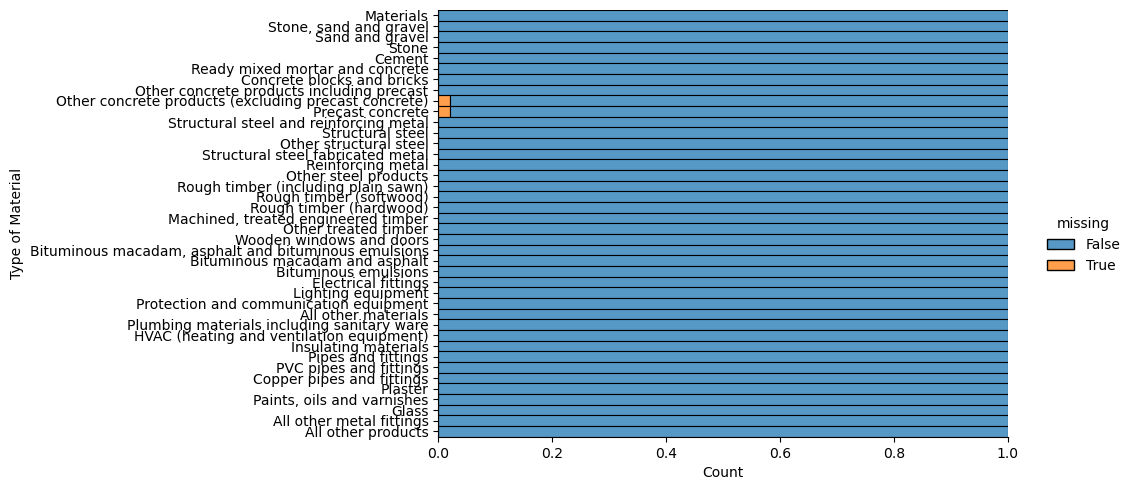

In [8]:
# seaborn visualisation
plt.figure(figsize=(18,6)) # setting figure size

ie_df.columns.name = 'Type of Material' # Assign the headers a name to reference in the plot

sns.displot( 
    data=ie_df.isna().melt(value_name="missing"), # indicating if missing value is true
    y='Type of Material',
    hue="missing",
    multiple="fill",
    aspect=2.1
);

In [9]:
# Locating where the missing values are within the dataset
ie_df[ie_df.isna().any(axis=1)]

Type of Material  Materials  Stone, sand and gravel  Sand and gravel  Stone  \
Month                                                                         
2023 February         144.0                   121.5            128.7  120.1   
2023 March            143.8                   120.9            120.9  120.9   

Type of Material  Cement  Ready mixed mortar and concrete  \
Month                                                       
2023 February      168.6                            143.4   
2023 March         168.6                            143.7   

Type of Material  Concrete blocks and bricks  \
Month                                          
2023 February                          130.0   
2023 March                             131.5   

Type of Material  Other concrete products including precast  \
Month                                                         
2023 February                                         129.9   
2023 March                                            129.9   

Type of Material  Other concrete products (excluding precast concrete)  \
Month                                                                    
2023 February                                                   NaN      
2023 March                                                      NaN      

Type of Material  Precast concrete  Structural steel and reinforcing metal  \
Month                                                                        
2023 February                  NaN                                   202.6   
2023 March                     NaN                                   201.4   

Type of Material  Structural steel  Other structural steel  \
Month                                                        
2023 February                221.9                   156.9   
2023 March                   221.6                   154.8   

Type of Material  Structural steel fabricated metal  Reinforcing metal  \
Month                                                                    
2023 February                                 229.9              173.2   
2023 March                                    229.9              170.6   

Type of Material  Other steel products  Rough timber (including plain sawn)  \
Month                                                                         
2023 February                    127.9                                151.4   
2023 March                       127.9                                151.4   

Type of Material  Rough timber (softwood)  Rough timber (hardwood)  \
Month                                                                
2023 February                       158.0                     98.9   
2023 March                          158.0                     98.9   

Type of Material  Machined, treated engineered timber  Other treated timber  \
Month                                                                         
2023 February                                   174.8                 216.6   
2023 March                                      174.8                 216.6   

Type of Material  Wooden windows and doors  \
Month                                        
2023 February                        140.2   
2023 March                           140.2   

Type of Material  Bituminous macadam, asphalt and bituminous emulsions  \
Month                                                                    
2023 February                                                 123.1      
2023 March                                                    123.0      

Type of Material  Bituminous macadam and asphalt  Bituminous emulsions  \
Month                                                                    
2023 February                              122.8                 131.6   
2023 March                                 122.7                 131.6   

Type of Material  Electrical fittings  Lighting equipment  \
Month                                                       
2023 February       

In [10]:
ie_df.ffill(inplace = True) ## Using ffill it will take the previous rows data to fill in the missing info

In [109]:
# Checking all missing data was filled
ie_df[ie_df.isna().any(axis=1)]

Empty DataFrame
Columns: [Materials, Stone, sand and gravel, Sand and gravel, Stone, Cement, Ready mixed mortar and concrete, Concrete blocks and bricks, Other concrete products including precast, Other concrete products (excluding precast concrete), Precast concrete, Structural steel and reinforcing metal, Structural steel, Other structural steel, Structural steel fabricated metal, Reinforcing metal, Other steel products, Rough timber (including plain sawn), Rough timber (softwood), Rough timber (hardwood), Machined, treated engineered timber, Other treated timber, Wooden windows and doors, Bituminous macadam, asphalt and bituminous emulsions, Bituminous macadam and asphalt, Bituminous emulsions, Electrical fittings, Lighting equipment, Protection and communication equipment, All other materials, Plumbing materials including sanitary ware, HVAC (heating and ventilation equipment), Insulating materials, Pipes and fittings, PVC pipes and fittings, Copper pipes and fittings, Plaster, Paints, oils and varnishes, Glass, All other metal fittings, All other products]
Index: []

In [94]:
duplicate_rows_df = ie_df[ie_df.duplicated()] # discovering duplicated rows
print("Number of duplicated rows in Irish dataset: ", len(duplicate_rows_df))

Number of duplicated rows in Irish dataset:  0


</br>

### UK Data

In [12]:
# Custom list with possible missing value formats
missing_value_formats = ["n.a.","?","NA" ,"Na", "n/a", "na", "--","N.A.","NaN", "None", "Null", 'c', 'C']

uk_df = pd.read_csv(download_destination + '/UK Data/UK_Building_Materials_CostIndex_Compiled.csv', index_col = 0, na_values = missing_value_formats)
uk_df

Materials    2017 February  \
0                                         - exclud...              127   
1            Sand & gravel           - including levy            121.7   
2               Coated roadstone     - excluding levy            113.2   
3                                             Cement             119.9   
4                             Ready-mixed concrete **            118.7   
5                          Pre-cast concrete products            119.4   
6           of which : Blocks, bricks, tiles  & fl...            123.7   
7                   Concrete reinforcing bars (steel)             92.7   
8                                         All Bricks             121.2   
9                                     Ceramic tiles *             c      
10                               Ceramic sanitaryware             c      
11                    Imported sawn or planed wood               106.3   
12                                   Imported plywood            108.1   
13                                       Sawn wood **            108.4   
14                                  Particle Board **            137.5   
15                               Builders woodwork **            115.4   
16                      of which : Doors & windows **            116.9   
17                        Fabricated structural steel             95.2   
18                                 Doors & windows **            119.4   
19                                       Screws etc *             c      
20                      Other builders' ironmongery**            115.1   
21                          Central heating boilers *             c      
22                   Taps and Valves for sanitaryware             c      
23                                Metal Sanitaryware*              109   
24                      Pipes and fittings (rigid) **            113.4   
25                   Pipes and fittings (flexible) **            110.6   
26                                    Sanitaryware **            114.1   
27                                 Doors & windows **              116   
28                                 Asphalt products *             92.9   
29         Insulating materials (thermal or acoustic)            123.4   
30                                    Paint (aqueous)            112.3   
31                               Paint (non-aqueous)             120.8   
32                   Lighting equipment for buildings             c      
33                    Lighting equipment for roads **             98.3   
34                         Electric heating apparatus            101.9   
35                           Electric water heaters *            120.5   
36                                 Kitchen furniture               112   

         2017 March       2017 April         2017 May        2017 June  \
0             126.9            126.6            126.2            124.1   
1             121.7            121.6            121.7            121.3   
2             113.2            113.2            113.2            113.2   
3             120.5            119.6            117.6            117.6   
4             117.7            117.9            118.3            119.4   
5               120              120            120.9            121.2   
6             124.6            124.7            125.9            126.4   
7              92.9               93             91.3             90.1   
8             120.4            121.6            122.3            123.8   
9              c                c                c                c      
10             c                c                c                c      
11            106.6              108            107.7            108.2   
12              109            106.8            105.7            107.5   
13            110.2            110.4            110.6            112.3   
14            137.5            138.7            138.7            139.7   
15            116.3            116.5           

In [13]:
cols = uk_df.columns.drop('Materials') # Select every feature except Materials
uk_df[cols] = uk_df[cols].apply(pd.to_numeric,errors='coerce') # Convert to numeric, any Null data will be converted to NaN
df_melted = uk_df.melt(id_vars=['Materials']) # Using Melt we can reformat the dataframe
df_melted.columns = df_melted.columns.str.replace('variable', 'Month') # Rename feature from variable to Month
df_melted.columns = df_melted.columns.str.replace('Materials', 'Type of Material') # Rename Materials feature to match Irish Dataset
df_melted

Type of Material           Month  value
0                                           - exclud...   2017 February  127.0
1              Sand & gravel           - including levy   2017 February  121.7
2                 Coated roadstone     - excluding levy   2017 February  113.2
3                                               Cement    2017 February  119.9
4                               Ready-mixed concrete **   2017 February  118.7
5                            Pre-cast concrete products   2017 February  119.4
6             of which : Blocks, bricks, tiles  & fl...   2017 February  123.7
7                     Concrete reinforcing bars (steel)   2017 February   92.7
8                                           All Bricks    2017 February  121.2
9                                       Ceramic tiles *   2017 February    NaN
10                                 Ceramic sanitaryware   2017 February    NaN
11                      Imported sawn or planed wood      2017 February  106.3
12                                     Imported plywood   2017 February  108.1
13                                         Sawn wood **   2017 February  108.4
14                                    Particle Board **   2017 February  137.5
15                                 Builders woodwork **   2017 February  115.4
16                        of which : Doors & windows **   2017 February  116.9
17                          Fabricated structural steel   2017 February   95.2
18                                   Doors & windows **   2017 February  119.4
19                                         Screws etc *   2017 February    NaN
20                        Other builders' ironmongery**   2017 February  115.1
21                            Central heating boilers *   2017 February    NaN
22                     Taps and Valves for sanitaryware   2017 February    NaN
23                                  Metal Sanitaryware*   2017 February  109.0
24                        Pipes and fittings (rigid) **   2017 February  113.4
25                     Pipes and fittings (flexible) **   2017 February  110.6
26                                      Sanitaryware **   2017 February  114.1
27                                   Doors & windows **   2017 February  116.0
28                                   Asphalt products *   2017 February   92.9
29           Insulating materials (thermal or acoustic)   2017 February  123.4
30                                      Paint (aqueous)   2017 February  112.3
31                                 Paint (non-aqueous)    2017 February  120.8
32                     Lighting equipment for buildings   2017 February    NaN
33                      Lighting equipment for roads **   2017 February   98.3
34                           Electric heating apparatus   2017 February  101.9
35                             Electric water heaters *   2017 February  120.5
36                                   Kitchen furniture    2017 February  112.0
37                                          - exclud...      2017 March  126.9
38             Sand & gravel           - including levy      2017 March  121.7
39                Coated roadstone     - excluding levy      2017 March  113.2
40                                              Cement       2017 March  120.5
41                              Ready-mixed concrete **      2017 March  117.7
42                           Pre-cast concrete products      2017 March  120.0
43            of which : Blocks, bricks, tiles  & fl...      2017 March  124.6
44                    Concrete reinforcing bars (steel)      2017 March   92.9
45                                          All Bricks       2017 March  120.4
46                                      Ceramic tiles *      2017 March    NaN
47                                 Ceramic sanitaryware      2017 March    NaN
48                      Imported sawn or planed wood         2017 March  106.6
49                                     Imported plywood      2017 March  109.0
50        

In [14]:
# Reshape the dataframe into the same format matching the Irish dataset
uk_df = df_melted.groupby(['Month','Type of Material'], sort=False)['value'].mean().unstack()
uk_df

Type of Material                                        - excluding levy  \
Month                                                                      
2017 February                                                 127.0        
2017 March                                                    126.9        
2017 April                                                    126.6        
2017 May                                                      126.2        
2017 June                                                     124.1        
2017 July                                                     125.3        
2017 August                                                   126.0        
2017 September                                                125.6        
2017 October                                                  125.6        
2017 November                                                 125.6        
2017 December                                                 125.6        
2018 January                                                  125.6        
2018 February                                                 125.6        
2018 March                                                    125.6        
2018 April                                                    125.6        
2018 May                                                      125.6        
2018 June                                                     125.6        
2018 July                                                     125.6        
2018 August                                                   125.6        
2018 September                                                125.6        
2018 October                                                  125.6        
2018 November                                                 125.6        
2018 December                                                 125.6        
2019 January                                                  125.6        
2019 February                                                 125.6        
2019 March                                                    125.6        
2019 April                                                    125.6        
2019 May                                                      125.6        
2019 June                                                     125.6        
2019 July                                                     125.6        
2019 August                                                   125.6        
2019 September                                                125.6        
2019 October                                                  125.6        
2019 November                                                 125.6        
2019 December                                                 125.6        
2020 January                                                  125.6        
2020 February                                                 125.6        
2020 March                                                      NaN        
2020 April                                                      NaN        
2020 May                                                        NaN        
2020 June                                                       NaN        
2020 July                                                       NaN        
2020 August                                                   110.6        
2020 September                                                110.7        
2020 October                                                  110.9        
2020 November                                                 116.8        
2020 December                                                 116.3        
2021 January                                                  115.9        
2021 February                                                 116.8        
2021 March                                                    112.1        
2021 April                                      

In [102]:
# Calculating percentage of missing data
quantity_missing = uk_df.isnull().sum(axis=0)
percent_missing = uk_df.isnull().sum(axis=0)/ len(uk_df)
missing_value_data = pd.DataFrame({'Quantity_missing': quantity_missing, 'Percentage_missing': percent_missing})
missing_value_data['Percentage_missing'] = missing_value_data['Percentage_missing'].map(lambda n: '{:,.2%}'.format(n))

missing_value_data[missing_value_data['Percentage_missing'].str.rstrip('%').astype('float') > 0] 
# View missing uk data above 5% which will have meaningful impact on final results within ML models

Empty DataFrame
Columns: [Quantity_missing, Percentage_missing]
Index: []

<Figure size 1800x600 with 0 Axes>

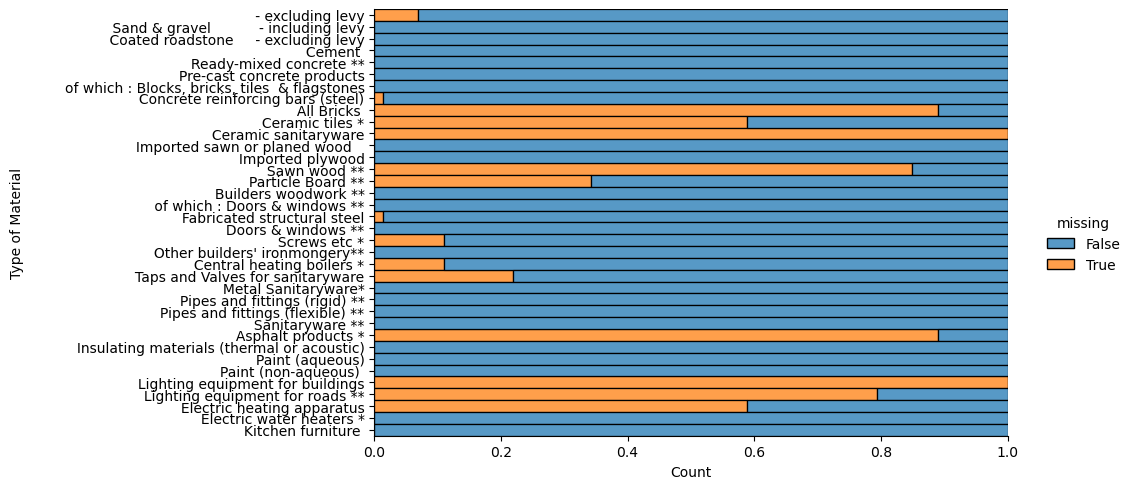

In [16]:
# seaborn visualisation
plt.figure(figsize=(18,6)) # setting figure size

sns.displot( 
    data=uk_df.isna().melt(value_name="missing"), # indicating if missing value is true
    y='Type of Material',
    hue="missing",
    multiple="fill",
    aspect=2.1
);

In [18]:
# It is apparent that the feature headers have many blank spaces within the names.
uk_df.columns = uk_df.columns.str.strip()
uk_df.columns
# To make it easier to call features by their names, blank spaces at beginning and end of strings will be removed

Index(['- excluding levy', 'Sand & gravel           - including levy',
       'Coated roadstone     - excluding levy', 'Cement',
       'Ready-mixed concrete **', 'Pre-cast concrete products',
       'of which : Blocks, bricks, tiles  & flagstones',
       'Concrete reinforcing bars (steel)', 'All Bricks', 'Ceramic tiles *',
       'Ceramic sanitaryware', 'Imported sawn or planed wood',
       'Imported plywood', 'Sawn wood **', 'Particle Board **',
       'Builders woodwork **', 'of which : Doors & windows **',
       'Fabricated structural steel', 'Doors & windows **', 'Screws etc *',
       'Other builders' ironmongery**', 'Central heating boilers *',
       'Taps and Valves for sanitaryware', 'Metal Sanitaryware*',
       'Pipes and fittings (rigid) **', 'Pipes and fittings (flexible) **',
       'Sanitaryware **', 'Asphalt products *',
       'Insulating materials (thermal or acoustic)', 'Paint (aqueous)',
       'Paint (non-aqueous)', 'Lighting equipment for buildings',
       'L

In [19]:
uk_df['Asphalt products *'].dropna() # Checking to see when valid data entries where made

Month
2017 February     92.9
2017 March        91.3
2017 April        91.3
2017 May          93.1
2017 June         91.3
2017 July         91.3
2017 August       93.2
2017 September    92.9
Name: Asphalt products *, dtype: float64

In [20]:
uk_df['All Bricks'].dropna() # Checking to see when valid data entries where made

Month
2017 February     121.2
2017 March        120.4
2017 April        121.6
2017 May          122.3
2017 June         123.8
2017 July         120.4
2017 August       124.1
2017 September    125.3
Name: All Bricks, dtype: float64

In [21]:
uk_df['Sawn wood **'].dropna() # Checking to see when valid data entries where made

Month
2017 February     108.4
2017 March        110.2
2017 April        110.4
2017 May          110.6
2017 June         112.3
2017 July         114.2
2017 August       114.3
2017 September    116.2
2017 October      117.0
2017 November     117.4
2017 December     118.6
Name: Sawn wood **, dtype: float64

In [22]:
uk_df['Lighting equipment for roads **'].dropna() # Checking to see when valid data entries where made

Month
2017 February      98.3
2017 March        100.8
2017 April        100.8
2017 May          100.8
2017 June         100.8
2017 July         100.8
2017 August       100.8
2017 September    100.8
2017 October      100.8
2017 November      99.5
2017 December      99.1
2018 January      102.0
2018 February     102.0
2018 March        100.0
2018 April         98.4
Name: Lighting equipment for roads **, dtype: float64

In [23]:
uk_df['Ceramic tiles *'].dropna() # Checking to see when valid data entries where made

Month
2017 October      95.4
2017 November     95.4
2017 December     95.4
2018 January      95.4
2018 February     96.2
2018 March        96.0
2018 April        96.0
2018 May          95.5
2018 June         95.5
2018 July         95.8
2018 August       95.8
2018 September    95.3
2018 October      95.3
2018 November     95.3
2018 December     95.3
2019 January      95.3
2019 February     95.4
2019 March        96.0
2019 April        96.9
2019 May          97.2
2019 June         97.1
2019 July         97.4
2019 August       97.3
2019 September    97.2
2019 October      96.9
2019 November     96.8
2019 December     96.6
2020 January      97.2
2020 February     97.4
2020 December     95.8
Name: Ceramic tiles *, dtype: float64

In [24]:
uk_df['Electric heating apparatus'].dropna() # Checking to see when valid data entries where made

Month
2017 February     101.9
2017 March        101.9
2017 April        106.7
2017 May          105.6
2017 June         105.3
2017 July         105.4
2017 August       103.1
2017 September    102.7
2018 June         102.1
2018 July         102.2
2018 August       100.3
2018 September    102.5
2018 October      101.5
2018 November     102.6
2018 December     102.1
2019 January      102.9
2019 February     102.9
2019 March        101.2
2019 April        100.9
2019 May          101.7
2019 June         103.3
2019 July         100.6
2019 August       103.3
2019 September    103.1
2019 October      103.1
2019 November     104.8
2019 December     106.5
2020 January      105.5
2020 February     106.6
2020 December     109.8
Name: Electric heating apparatus, dtype: float64

In [25]:
uk_df['Particle Board **'].dropna() # Checking to see when valid data entries where made

Month
2017 February     137.5
2017 March        137.5
2017 April        138.7
2017 May          138.7
2017 June         139.7
2017 July         144.5
2017 August       145.1
2017 September    145.3
2017 October      146.3
2017 November     146.7
2017 December     146.9
2018 January      147.4
2020 March        104.7
2020 April        103.4
2020 May          105.1
2020 June         106.2
2020 July         105.1
2020 August       107.5
2020 September    109.3
2020 October      113.8
2020 November     116.0
2020 December     116.4
2021 January      122.0
2021 February     122.7
2021 March        123.7
2021 April        128.9
2021 May          131.2
2021 June         144.5
2021 July         152.0
2021 August       179.7
2021 September    173.9
2021 October      184.9
2021 November     182.1
2021 December     173.9
2022 January      173.4
2022 February     173.7
2022 March        170.4
2022 April        171.0
2022 May          168.0
2022 June         170.3
2022 July         162.2
2022 Augus

In [26]:
uk_df['Taps and Valves for sanitaryware'].dropna() # Checking to see when valid data entries where made

Month
2018 June         126.9
2018 July         128.0
2018 August       128.8
2018 September    128.8
2018 October      131.0
2018 November     131.0
2018 December     131.0
2019 January      132.6
2019 February     132.6
2019 March        142.7
2019 April        143.1
2019 May          144.0
2019 June         144.0
2019 July         144.0
2019 August       144.0
2019 September    144.0
2019 October      144.0
2019 November     144.0
2019 December     144.1
2020 January      145.5
2020 February     147.5
2020 March        124.1
2020 April        124.1
2020 May          124.1
2020 June         124.1
2020 July         124.1
2020 August       125.3
2020 September    125.3
2020 October      125.3
2020 November     125.3
2020 December     125.5
2021 January      128.4
2021 February     128.4
2021 March        128.0
2021 April        129.1
2021 May          132.9
2021 June         132.9
2021 July         132.9
2021 August       133.3
2021 September    133.3
2021 October      133.7
2021 Novem

In [27]:
uk_df['Central heating boilers *'].dropna() # Checking to see when valid data entries where made

Month
2017 October      123.7
2017 November     124.0
2017 December     124.0
2018 January      124.0
2018 February     125.2
2018 March        125.4
2018 April        125.4
2018 May          127.7
2018 June         127.7
2018 July         127.7
2018 August       127.8
2018 September    127.8
2018 October      127.8
2018 November     127.8
2018 December     127.8
2019 January      128.5
2019 February     129.0
2019 March        129.0
2019 April        129.0
2019 May          129.0
2019 June         129.0
2019 July         129.0
2019 August       129.1
2019 September    131.4
2019 October      131.4
2019 November     131.4
2019 December     131.4
2020 January      131.4
2020 February     131.3
2020 March        118.6
2020 April        118.6
2020 May          118.6
2020 June         118.6
2020 July         118.6
2020 August       118.6
2020 September    118.6
2020 October      118.6
2020 November     120.3
2020 December     120.3
2021 January      120.4
2021 February     120.4
2021 March

In [28]:
uk_df['Screws etc *'].dropna() # Checking to see when valid data entries where made

Month
2017 October      103.3
2017 November     103.4
2017 December     103.5
2018 January      103.8
2018 February     104.0
2018 March        104.2
2018 April        104.5
2018 May          104.8
2018 June         105.1
2018 July         105.6
2018 August       106.0
2018 September    105.9
2018 October      105.3
2018 November     105.2
2018 December     106.1
2019 January      105.5
2019 February     105.5
2019 March        104.1
2019 April        104.1
2019 May          104.1
2019 June         111.8
2019 July         111.8
2019 August       111.8
2019 September    111.8
2019 October      111.8
2019 November     111.8
2019 December     111.8
2020 January      111.8
2020 February     108.9
2020 March        106.4
2020 April        106.4
2020 May          106.4
2020 June         106.4
2020 July         106.4
2020 August       106.4
2020 September    106.4
2020 October      106.4
2020 November     106.4
2020 December     106.4
2021 January       91.4
2021 February      91.4
2021 March

In [29]:
uk_df['- excluding levy'].dropna() # Checking to see when valid data entries where made

Month
2017 February     127.0
2017 March        126.9
2017 April        126.6
2017 May          126.2
2017 June         124.1
2017 July         125.3
2017 August       126.0
2017 September    125.6
2017 October      125.6
2017 November     125.6
2017 December     125.6
2018 January      125.6
2018 February     125.6
2018 March        125.6
2018 April        125.6
2018 May          125.6
2018 June         125.6
2018 July         125.6
2018 August       125.6
2018 September    125.6
2018 October      125.6
2018 November     125.6
2018 December     125.6
2019 January      125.6
2019 February     125.6
2019 March        125.6
2019 April        125.6
2019 May          125.6
2019 June         125.6
2019 July         125.6
2019 August       125.6
2019 September    125.6
2019 October      125.6
2019 November     125.6
2019 December     125.6
2020 January      125.6
2020 February     125.6
2020 August       110.6
2020 September    110.7
2020 October      110.9
2020 November     116.8
2020 Decem

In [30]:
# Drop features which express too much missing data
uk_df = uk_df.drop(columns=['Ceramic sanitaryware', 
                    'Lighting equipment for buildings', 
                    'Asphalt products *', 
                    'All Bricks',
                    'Sawn wood **',
                    'Lighting equipment for roads **',
                    'Ceramic tiles *',
                    'Electric heating apparatus'
                   ])

In [35]:
uk_df.columns = uk_df.columns.str.replace('Sand & gravel           - including levy', 'Sand & gravel - including levy') # Rename feature
uk_df.columns = uk_df.columns.str.replace('- excluding levy', 'Sand & gravel - excluding levy') # Rename feature

In [37]:
# Use backfill as the missing information is located at the beginning of the dataset
uk_df['Screws etc *'].bfill(inplace = True) 
uk_df['Central heating boilers *'].bfill(inplace = True)

# Use forward fill as the missing information is centrally located within the dataset
uk_df['Sand & gravel - excluding levy'].ffill(inplace = True)
uk_df['Fabricated structural steel'].ffill(inplace = True) 
uk_df['Concrete reinforcing bars (steel)'].ffill(inplace = True) 

### Using ML: Multiple Linear Regression model to predict and replace missing values

#### 1) Taps and Valves for sanitaryware

In [51]:
# Replacing <NaN> Values using Machine learning: Linear regression model
uk_dropped_missing = uk_df.drop(columns = ['Particle Board **'])
test_data = uk_dropped_missing[uk_dropped_missing.isnull().any(axis=1)] # Extract only null values to make testing set
train_data = uk_dropped_missing.dropna() # Drop null values to create training set

In [55]:
# Create x_train & y_train from training set
X_train = train_data.drop('Taps and Valves for sanitaryware', axis=1)
y_train = train_data['Taps and Valves for sanitaryware']

In [58]:
# Build linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train) # Fit train data to the Linear Regression model.

LinearRegression()

In [59]:
# Now model is ready to be tested.
# Need to create x_train from testing set
X_test = test_data.drop(columns = ['Taps and Valves for sanitaryware'])

In [66]:
y_pred = lr.predict(X_test)
y_pred

array([119.77221692, 121.15204507, 120.83213092, 120.21270733,
       121.234972  , 122.32823775, 122.58736969, 122.15465031,
       122.31333878, 121.84801907, 121.36017406, 124.74911399,
       125.41052647, 128.79653892, 128.74739538, 128.06353614])

In [97]:
y_pred_rounded = [round(pred, 1) for pred in y_pred] # Round to 1 decimal place matching format of existing data
test_data['Taps and Valves for sanitaryware'] = y_pred_rounded # assign back to the testing data
# Update original dataframe with new values
uk_df.update(test_data)

/var/folders/s2/43wrtj7n0jv6ln1rpm789j180000gn/T/ipykernel_92929/2164533400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Taps and Valves for sanitaryware'] = y_pred_rounded # assign back to the testing data


#### 2) Particle Board **

In [82]:
# Replacing <NaN> Values using Machine learning: Linear regression model
test_data = uk_df[uk_df.isnull().any(axis=1)] # Extract only null values to make testing set
train_data = uk_df.dropna() # Drop null values to create training set

In [84]:
# Create x_train & y_train from training set
X_train = train_data.drop('Particle Board **', axis=1)
y_train = train_data['Particle Board **']

In [86]:
# Build linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train) # Fit train data to the Linear Regression model.

LinearRegression()

In [87]:
# Now model is ready to be tested.
# Need to create x_train from testing set
X_test = test_data.drop(columns = ['Particle Board **'])

In [88]:
y_pred = lr.predict(X_test)
y_pred

array([148.32586997, 151.85009541, 156.00718917, 153.99479689,
       157.44769548, 157.81903749, 156.48674293, 164.6905903 ,
       162.38331867, 163.76204098, 164.99784833, 161.03720264,
       161.43506788, 152.15351737, 149.96637686, 134.83147396,
       140.60880953, 136.09293764, 138.61416899, 131.06106245,
       129.32504439, 129.08135467, 129.88233844, 128.1825922 ,
       127.67747367])

In [96]:
y_pred_rounded = [round(pred, 1) for pred in y_pred] # Round to 1 decimal place matching format of existing data
test_data['Particle Board **'] = y_pred_rounded # assign back to the testing data
# Update original dataframe with new values
uk_df.update(test_data)

/var/folders/s2/43wrtj7n0jv6ln1rpm789j180000gn/T/ipykernel_92929/96504245.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Particle Board **'] = y_pred_rounded # assign back to the testing data


<Figure size 1800x600 with 0 Axes>

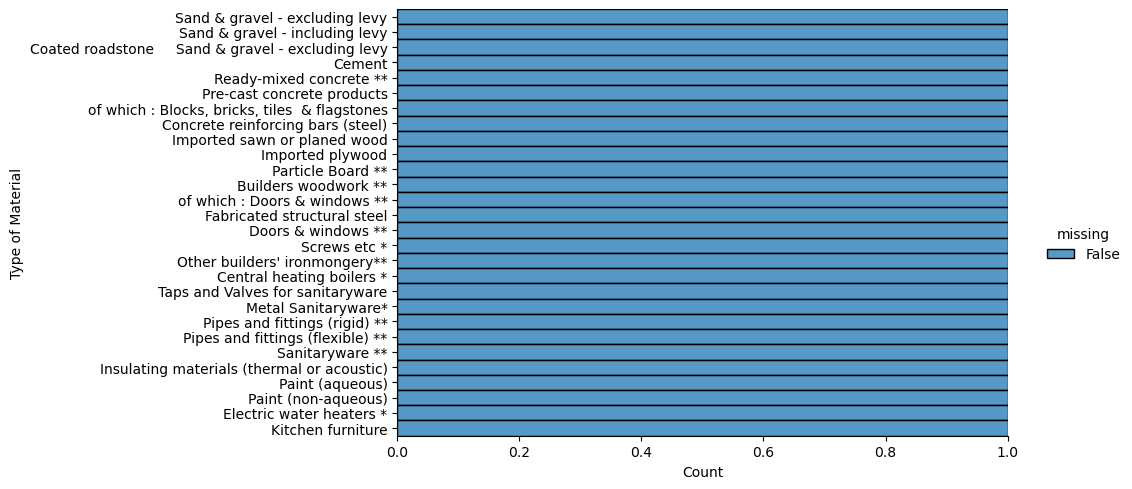

In [100]:
# seaborn visualisation
plt.figure(figsize=(18,6)) # setting figure size

sns.displot( 
    data=uk_df.isna().melt(value_name="missing"), # indicating if missing value is true
    y='Type of Material',
    hue="missing",
    multiple="fill",
    aspect=2.1
);


print(uk_df)

In [110]:
# Checking all missing data was filled
uk_df[uk_df.isna().any(axis=1)]

Empty DataFrame
Columns: [Sand & gravel - excluding levy, Sand & gravel - including levy, Coated roadstone     Sand & gravel - excluding levy, Cement, Ready-mixed concrete **, Pre-cast concrete products, of which : Blocks, bricks, tiles  & flagstones, Concrete reinforcing bars (steel), Imported sawn or planed wood, Imported plywood, Particle Board **, Builders woodwork **, of which : Doors & windows **, Fabricated structural steel, Doors & windows **, Screws etc *, Other builders' ironmongery**, Central heating boilers *, Taps and Valves for sanitaryware, Metal Sanitaryware*, Pipes and fittings (rigid) **, Pipes and fittings (flexible) **, Sanitaryware **, Insulating materials (thermal or acoustic), Paint (aqueous), Paint (non-aqueous), Electric water heaters *, Kitchen furniture]
Index: []

In [95]:
duplicate_rows_df = uk_df[uk_df.duplicated()] # discovering duplicated rows
print("Number of duplicated rows in UK dataset: ", len(duplicate_rows_df))

Number of duplicated rows in UK dataset:  0


</br>

## Data Understanding 

In [113]:
ie_df

Type of Material  Materials  Stone, sand and gravel  Sand and gravel  Stone  \
Month                                                                         
2015 January           99.2                    95.7             98.0   95.3   
2015 February          99.0                    93.9             96.1   93.5   
2015 March             99.5                    98.1             97.5   98.2   
2015 April             99.8                    99.9            106.2   98.7   
2015 May              100.2                   100.5            103.1  100.0   
2015 June             100.6                   103.7            100.3  104.3   
2015 July             100.4                   103.0            100.1  103.6   
2015 August           100.4                   102.8             99.7  103.4   
2015 September        100.3                   101.9             98.6  102.5   
2015 October          100.0                   101.2            103.8  100.7   
2015 November         100.4                   101.4             97.4  102.1   
2015 December         100.1                    97.8             99.2   97.6   
2016 January          100.1                    97.1            100.2   96.4   
2016 February          99.6                    98.3            108.2   96.3   
2016 March             99.8                    97.3            103.1   96.1   
2016 April            100.4                   100.6            103.2  100.1   
2016 May              100.7                   104.7            108.0  104.0   
2016 June             100.8                   106.9            108.4  106.6   
2016 July             101.0                   107.2            104.3  107.8   
2016 August           101.0                   106.2            109.5  105.5   
2016 September        101.2                   105.9            111.0  104.9   
2016 October          101.3                   107.4            120.4  104.8   
2016 November         101.6                   106.6            123.1  103.3   
2016 December         101.6                   104.7            119.7  101.7   
2017 January          101.8                   102.6            120.4   99.1   
2017 February         101.8                   101.9            114.0   99.4   
2017 March            102.9                   104.5            117.3  101.9   
2017 April            103.0                   107.8            123.6  104.6   
2017 May              103.5                   109.9            123.0  107.3   
2017 June             103.5                   110.9            127.5  107.5   
2017 July             103.8                   114.0            124.6  111.9   
2017 August           103.8                   111.8            124.3  109.3   
2017 September        104.0                   112.1            120.4  110.4   
2017 October          104.0                   111.8            121.4  109.8   
2017 November         103.7                   107.0            118.5  104.7   
2017 December         104.0                   110.1            124.0  107.3   
2018 January          103.8                   106.2            117.8  103.8   
2018 February         103.9                   106.7            120.0  104.0   
2018 March            104.3                   106.6            121.8  103.5   
2018 April            103.9                   104.5            113.0  102.8   
2018 May              104.0                   106.0            111.6  104.9   
2018 June             104.1                   105.5            111.4  104.4   
2018 July             104.8                   107.9            116.1  106.3   
2018 August           104.8                   106.1            116.7  104.0   
2018 September        104.5                   104.7            111.6  103.3   
2018 October          104.1                   105.0            111.8  103.7   
2018 November         104.2                   104.2            114.0  102.2   
2018 December         104.4                   104.2            113.0  102.4   
2019 January          105.0                   103.

In [169]:
i = ie_df.columns
list(i)

['Materials',
 'Stone, sand and gravel',
 'Sand and gravel',
 'Stone',
 'Cement',
 'Ready mixed mortar and concrete',
 'Concrete blocks and bricks',
 'Other concrete products including precast',
 'Other concrete products (excluding precast concrete)',
 'Precast concrete',
 'Structural steel and reinforcing metal',
 'Structural steel',
 'Other structural steel',
 'Structural steel fabricated metal',
 'Reinforcing metal',
 'Other steel products',
 'Rough timber (including plain sawn)',
 'Rough timber (softwood)',
 'Rough timber (hardwood)',
 'Machined, treated engineered timber',
 'Other treated timber',
 'Wooden windows and doors',
 'Bituminous macadam, asphalt and bituminous emulsions',
 'Bituminous macadam and asphalt',
 'Bituminous emulsions',
 'Electrical fittings',
 'Lighting equipment',
 'Protection and communication equipment',
 'All other materials',
 'Plumbing materials including sanitary ware',
 'HVAC (heating and ventilation equipment)',
 'Insulating materials',
 'Pipes and f

In [170]:
u = uk_df.columns
list(u)

['Sand & gravel - excluding levy',
 'Sand & gravel - including levy',
 'Coated roadstone     Sand & gravel - excluding levy',
 'Cement',
 'Ready-mixed concrete **',
 'Pre-cast concrete products',
 'of which : Blocks, bricks, tiles  & flagstones',
 'Concrete reinforcing bars (steel)',
 'Imported sawn or planed wood',
 'Imported plywood',
 'Particle Board **',
 'Builders woodwork **',
 'of which : Doors & windows **',
 'Fabricated structural steel',
 'Doors & windows **',
 'Screws etc *',
 "Other builders' ironmongery**",
 'Central heating boilers *',
 'Taps and Valves for sanitaryware',
 'Metal Sanitaryware*',
 'Pipes and fittings (rigid) **',
 'Pipes and fittings (flexible) **',
 'Sanitaryware **',
 'Insulating materials (thermal or acoustic)',
 'Paint (aqueous)',
 'Paint (non-aqueous)',
 'Electric water heaters *',
 'Kitchen furniture']

#### Dictionary of similar data entries from Ireland and UK 

In [200]:
common_list_dict = {'Cement' : 'Cement', 
               'Sand and gravel' : 'Sand & gravel - including levy', 
               'Ready mixed mortar and concrete' : 'Ready-mixed concrete **',
               'Concrete blocks and bricks' : 'of which : Blocks, bricks, tiles  & flagstones',
               'Other concrete products including precast' : 'Pre-cast concrete products',
               'Structural steel fabricated metal' : 'Fabricated structural steel',
               'Reinforcing metal' : 'Concrete reinforcing bars (steel)',
               'Rough timber (including plain sawn)': 'Imported sawn or planed wood',
               'Machined, treated engineered timber' : 'Imported plywood',
               'Other treated timber' : 'Particle Board **',
               'Wooden windows and doors' : 'of which : Doors & windows **',
               'Plumbing materials including sanitary ware' : 'Taps and Valves for sanitaryware',
               'HVAC (heating and ventilation equipment)' : 'Central heating boilers *',
               'HVAC (heating and ventilation equipment)' : 'Electric water heaters *',
               'Insulating materials' : 'Insulating materials (thermal or acoustic)',
               'Copper pipes and fittings' : 'Pipes and fittings (rigid) **',
               'Pipes and fittings' : 'Pipes and fittings (flexible) **',
               'Paints, oils and varnishes' : 'Paint (aqueous)',
               'Paints, oils and varnishes' : 'Paint (non-aqueous)',
              }

#### IE data insights

In [201]:
cols = common_list_dict.keys()
print(list(cols))

['Cement', 'Sand and gravel', 'Ready mixed mortar and concrete', 'Concrete blocks and bricks', 'Other concrete products including precast', 'Structural steel fabricated metal', 'Reinforcing metal', 'Rough timber (including plain sawn)', 'Machined, treated engineered timber', 'Other treated timber', 'Wooden windows and doors', 'Plumbing materials including sanitary ware', 'HVAC (heating and ventilation equipment)', 'Insulating materials', 'Copper pipes and fittings', 'Pipes and fittings', 'Paints, oils and varnishes']


In [329]:
ncols = list(cols)
new_ie_df = ie_df[ncols]
new_ie_df

Type of Material  Cement  Sand and gravel  Ready mixed mortar and concrete  \
Month                                                                        
2015 January       100.0             98.0                            101.6   
2015 February      100.0             96.1                            100.4   
2015 March         100.0             97.5                            100.1   
2015 April         100.0            106.2                             99.8   
2015 May           100.0            103.1                             99.6   
2015 June          100.0            100.3                            100.4   
2015 July          100.0            100.1                            100.0   
2015 August        100.0             99.7                             99.9   
2015 September     100.0             98.6                             99.6   
2015 October       100.0            103.8                             97.7   
2015 November      100.0             97.4                            100.4   
2015 December      100.0             99.2                            100.5   
2016 January       100.0            100.2                            100.9   
2016 February      100.0            108.2                             99.7   
2016 March         100.0            103.1                            100.0   
2016 April         100.0            103.2                             99.8   
2016 May           100.0            108.0                            100.0   
2016 June          100.0            108.4                             99.6   
2016 July          100.0            104.3                             97.5   
2016 August        100.0            109.5                             99.9   
2016 September     100.0            111.0                            101.6   
2016 October       100.0            120.4                             99.7   
2016 November      100.0            123.1                            101.7   
2016 December      100.0            119.7                            101.5   
2017 January       100.0            120.4                            101.9   
2017 February      100.0            114.0                            100.3   
2017 March         100.0            117.3                            100.2   
2017 April         104.4            123.6                             99.7   
2017 May           104.4            123.0                            100.0   
2017 June          104.4            127.5                            101.4   
2017 July          104.4            124.6                            101.4   
2017 August        104.4            124.3                            102.1   
2017 September     104.4            120.4                            101.8   
2017 October       104.4            121.4                            100.8   
2017 November      104.4            118.5                            100.7   
2017 December      104.4            124.0                            101.4   
2018 January       108.4            117.8                            101.1   
2018 February      108.4            120.0                            101.0   
2018 March         108.4            121.8                            103.1   
2018 April         108.4            113.0                            100.6   
2018 May           108.4            111.6                             99.1   
2018 June          108.4            111.4                             99.1   
2018 July          108.4            116.1                            100.5   
2018 August        108.4            116.7                            103.1   
2018 September     108.4            111.6                            101.3   
2018 October       108.4            111.8                             98.7   
2018 November      108.4            114.0                             99.4   
2018 December      108.4            113.0                            100.8   
2019 January       114.6            112.4                            103.0   
2019 February      114

In [334]:
avg_monthly_pct_change = new_ie_df.pct_change(periods=1) * 100
avg_monthly_pct_change = avg_monthly_pct_change.fillna(0)
avg_monthly_pct_change

Type of Material    Cement  Sand and gravel  Ready mixed mortar and concrete  \
Month                                                                          
2015 January      0.000000         0.000000                         0.000000   
2015 February     0.000000        -1.938776                        -1.181102   
2015 March        0.000000         1.456816                        -0.298805   
2015 April        0.000000         8.923077                        -0.299700   
2015 May          0.000000        -2.919021                        -0.200401   
2015 June         0.000000        -2.715810                         0.803213   
2015 July         0.000000        -0.199402                        -0.398406   
2015 August       0.000000        -0.399600                        -0.100000   
2015 September    0.000000        -1.103310                        -0.300300   
2015 October      0.000000         5.273834                        -1.907631   
2015 November     0.000000        -6.165703                         2.763562   
2015 December     0.000000         1.848049                         0.099602   
2016 January      0.000000         1.008065                         0.398010   
2016 February     0.000000         7.984032                        -1.189296   
2016 March        0.000000        -4.713494                         0.300903   
2016 April        0.000000         0.096993                        -0.200000   
2016 May          0.000000         4.651163                         0.200401   
2016 June         0.000000         0.370370                        -0.400000   
2016 July         0.000000        -3.782288                        -2.108434   
2016 August       0.000000         4.985618                         2.461538   
2016 September    0.000000         1.369863                         1.701702   
2016 October      0.000000         8.468468                        -1.870079   
2016 November     0.000000         2.242525                         2.006018   
2016 December     0.000000        -2.761982                        -0.196657   
2017 January      0.000000         0.584795                         0.394089   
2017 February     0.000000        -5.315615                        -1.570167   
2017 March        0.000000         2.894737                        -0.099701   
2017 April        4.400000         5.370844                        -0.499002   
2017 May          0.000000        -0.485437                         0.300903   
2017 June         0.000000         3.658537                         1.400000   
2017 July         0.000000        -2.274510                         0.000000   
2017 August       0.000000        -0.240770                         0.690335   
2017 September    0.000000        -3.137570                        -0.293830   
2017 October      0.000000         0.830565                        -0.982318   
2017 November     0.000000        -2.388797                        -0.099206   
2017 December     0.000000         4.641350                         0.695134   
2018 January      3.831418        -5.000000                        -0.295858   
2018 February     0.000000         1.867572                        -0.098912   
2018 March        0.000000         1.500000                         2.079208   
2018 April        0.000000        -7.224959                        -2.424830   
2018 May          0.000000        -1.238938                        -1.491054   
2018 June         0.000000        -0.179211                         0.000000   
2018 July         0.000000         4.219031                         1.412714   
2018 August       0.000000         0.516796                         2.587065   
2018 September    0.000000        -4.370180                        -1.745878   
2018 October      0.000000         0.179211                        -2.566634   
2018 November     0.000000         1.967800                         0.709220   
2018 December     0.000000        -0.877193                         1.408451   


/var/folders/s2/43wrtj7n0jv6ln1rpm789j180000gn/T/ipykernel_92929/566825364.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.1%}'.format(x/100) for x in vals])


[Text(5, 0, '0.54%'),
 Text(5, 0, '0.37%'),
 Text(5, 0, '0.36%'),
 Text(5, 0, '0.28%'),
 Text(5, 0, '0.28%'),
 Text(5, 0, '0.94%'),
 Text(5, 0, '0.57%'),
 Text(5, 0, '0.47%'),
 Text(5, 0, '0.62%'),
 Text(5, 0, '1.02%'),
 Text(5, 0, '0.36%'),
 Text(5, 0, '0.42%'),
 Text(5, 0, '0.17%'),
 Text(5, 0, '0.27%'),
 Text(5, 0, '0.38%'),
 Text(5, 0, '0.42%'),
 Text(5, 0, '0.45%')]

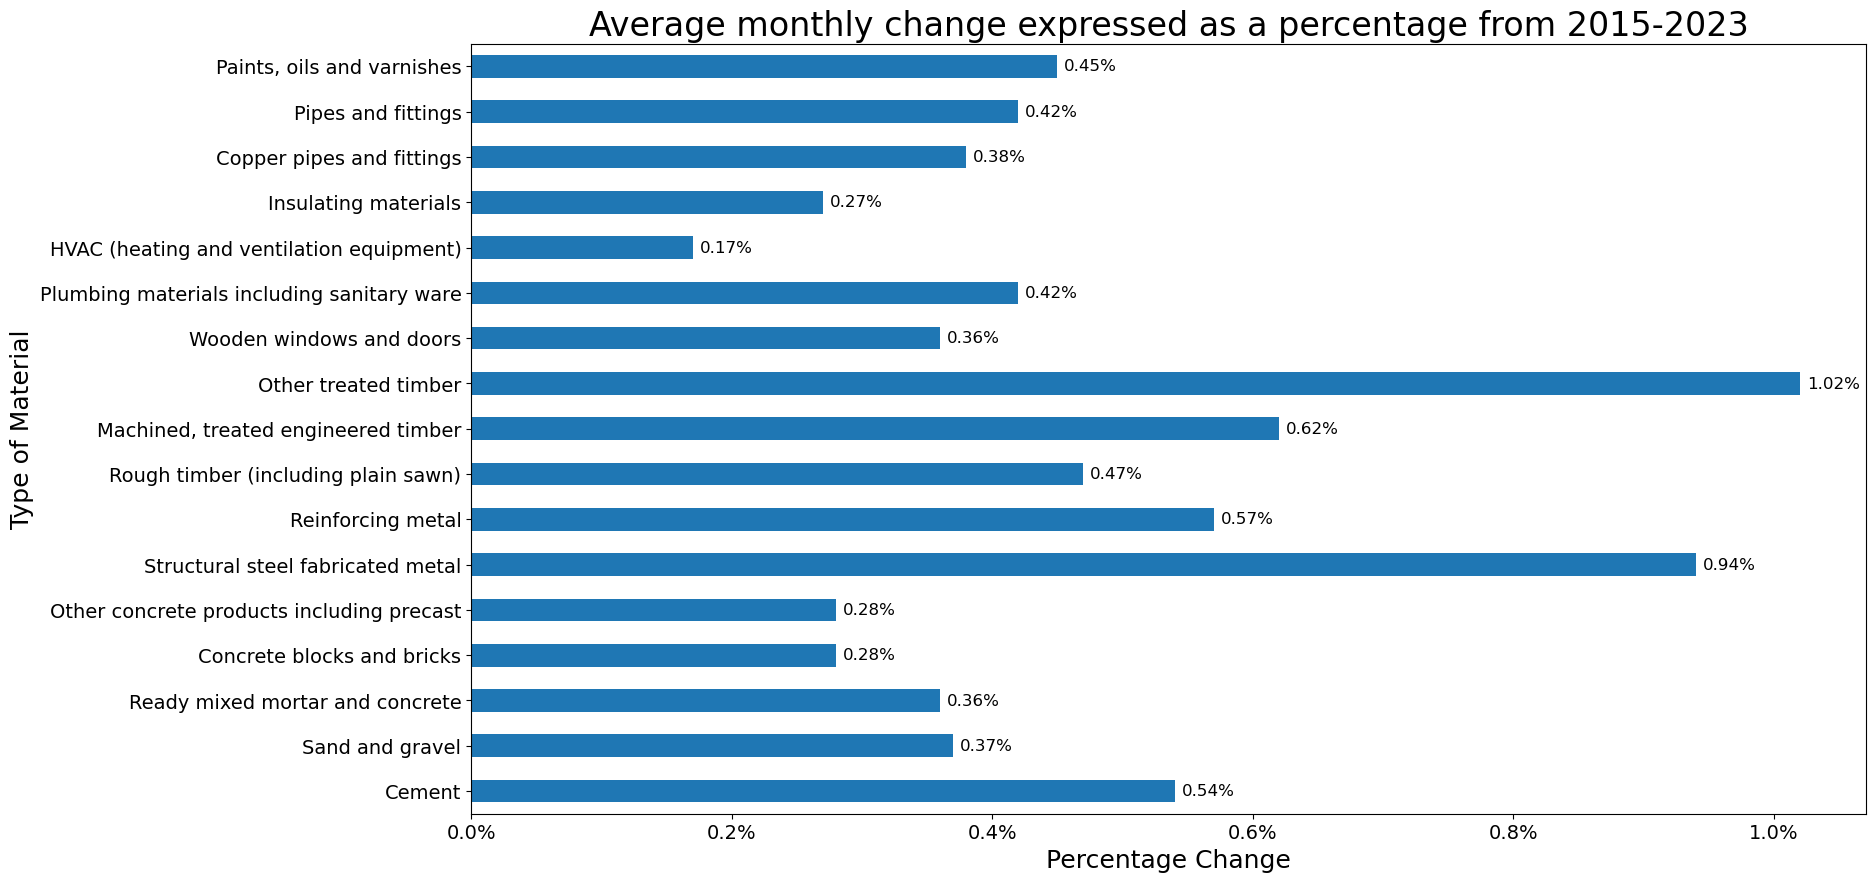

In [335]:
avg_monthly_pct_change = round(avg_monthly_pct_change.mean(), 2)

plt.figure(figsize=(18,10))
ax = avg_monthly_pct_change.plot.barh()

plt.title("Mean IE monthly change expressed as a percentage from 2015-2023", fontsize="24")
plt.xlabel("Percentage Change", fontsize="18")
plt.ylabel("Type of Material", fontsize="18")
plt.xticks(size = 14)
plt.yticks(size = 14)

vals = ax.get_xticks()
ax.set_xticklabels(['{:,.1%}'.format(x/100) for x in vals])

plt.bar_label(ax.containers[0], padding = 5 , size=12 , fmt='%.2f%%')

In [342]:
avg_monthly_pct_change.sort_values(ascending = False)

Type of Material
Other treated timber                          1.02
Structural steel fabricated metal             0.94
Machined, treated engineered timber           0.62
Reinforcing metal                             0.57
Cement                                        0.54
Rough timber (including plain sawn)           0.47
Paints, oils and varnishes                    0.45
Plumbing materials including sanitary ware    0.42
Pipes and fittings                            0.42
Copper pipes and fittings                     0.38
Sand and gravel                               0.37
Ready mixed mortar and concrete               0.36
Wooden windows and doors                      0.36
Other concrete products including precast     0.28
Concrete blocks and bricks                    0.28
Insulating materials                          0.27
HVAC (heating and ventilation equipment)      0.17
dtype: float64

highest costs are for structural dependant materials. Anything required to build the skeleton of the building.

/var/folders/s2/43wrtj7n0jv6ln1rpm789j180000gn/T/ipykernel_92929/1358316642.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.1%}'.format(x/100) for x in vals])


[Text(5, 0, '6.48%'),
 Text(5, 0, '4.44%'),
 Text(5, 0, '4.32%'),
 Text(5, 0, '3.36%'),
 Text(5, 0, '3.36%'),
 Text(5, 0, '11.28%'),
 Text(5, 0, '6.84%'),
 Text(5, 0, '5.64%'),
 Text(5, 0, '7.44%'),
 Text(5, 0, '12.24%'),
 Text(5, 0, '4.32%'),
 Text(5, 0, '5.04%'),
 Text(5, 0, '2.04%'),
 Text(5, 0, '3.24%'),
 Text(5, 0, '4.56%'),
 Text(5, 0, '5.04%'),
 Text(5, 0, '5.40%')]

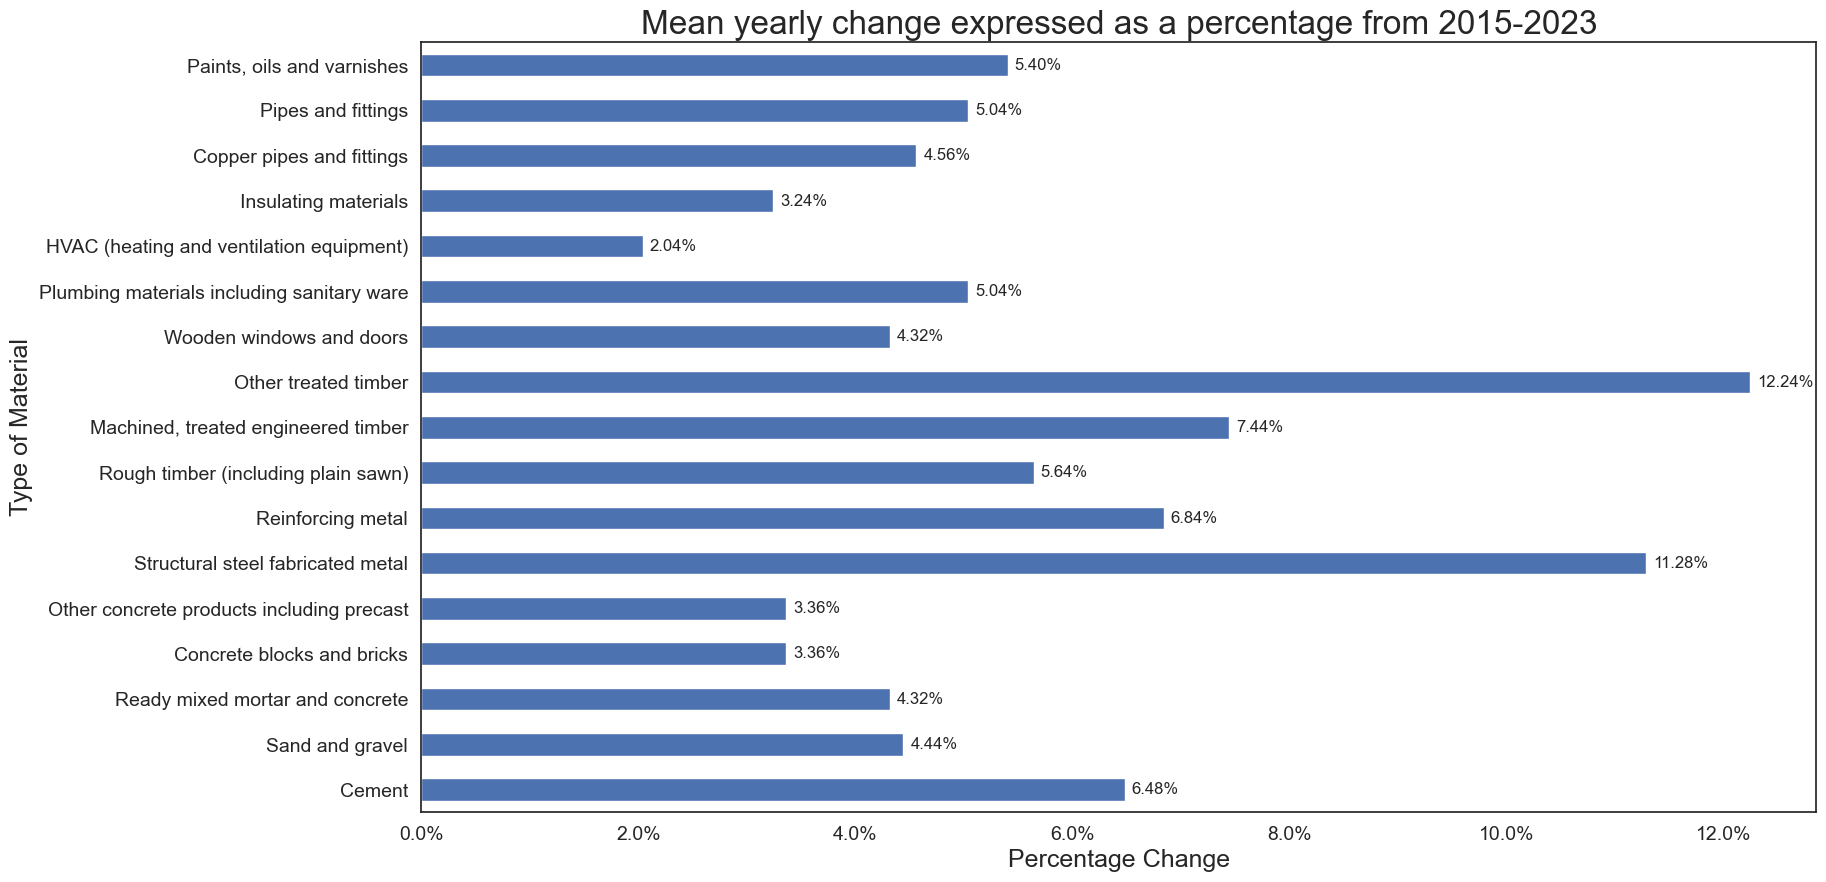

In [455]:
avg_yearly_pct_change = avg_monthly_pct_change * 12

plt.figure(figsize=(18,10))
ax = avg_yearly_pct_change.plot.barh()

plt.title("Mean IE yearly change expressed as a percentage from 2015-2023", fontsize="24")
plt.xlabel("Percentage Change", fontsize="18")
plt.ylabel("Type of Material", fontsize="18")
plt.xticks(size = 14)
plt.yticks(size = 14)

vals = ax.get_xticks()
ax.set_xticklabels(['{:,.1%}'.format(x/100) for x in vals])

plt.bar_label(ax.containers[0], padding = 5 , size=12 , fmt='%.2f%%')

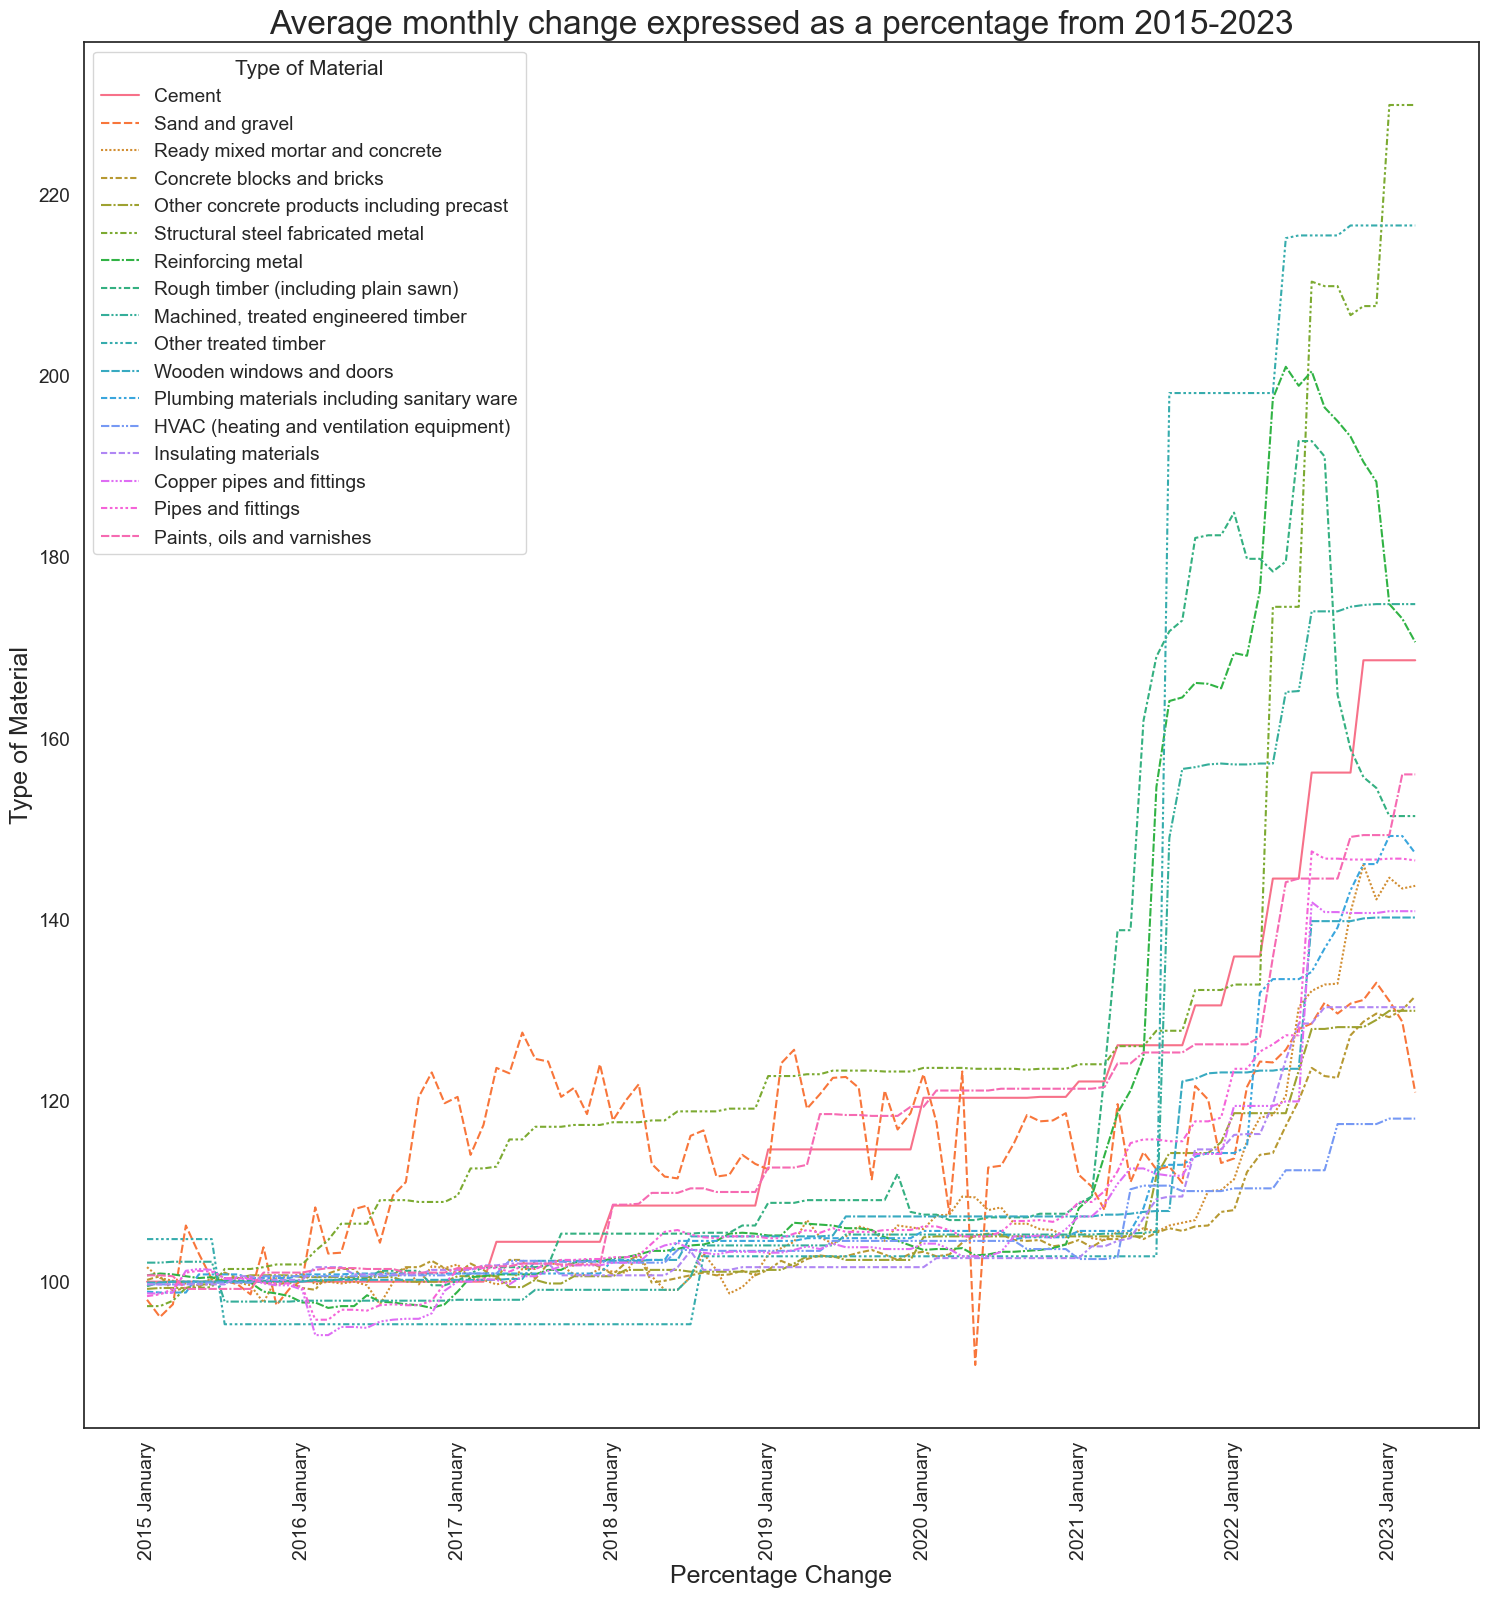

In [450]:
plt.figure(figsize=(18,18))

sns_plot = sns.lineplot(data = new_ie_df , ci = None)

plt.title("Average IE monthly change expressed as a percentage from 2015-2023", fontsize="24")
plt.xlabel("Percentage Change", fontsize="18")
plt.ylabel("Type of Material", fontsize="18")
plt.xticks(plt.xticks()[0], rotation=90, size = 14)
sns_plot.xaxis.get_major_locator()  
sns_plot.xaxis.set_major_locator(ticker.MultipleLocator(12))

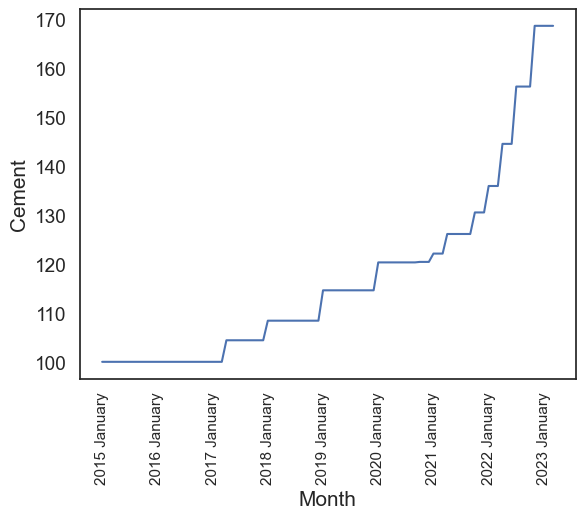

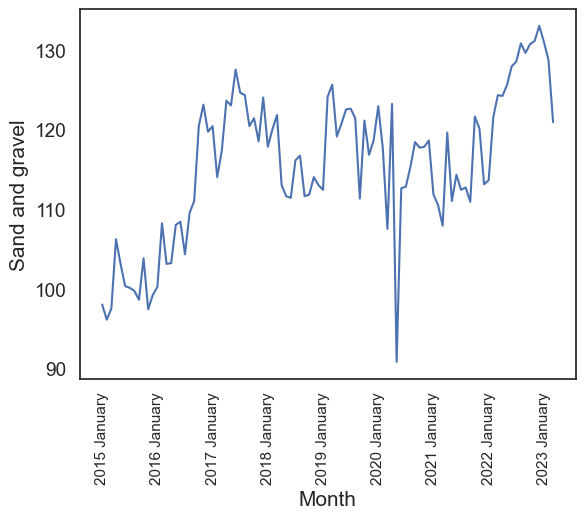

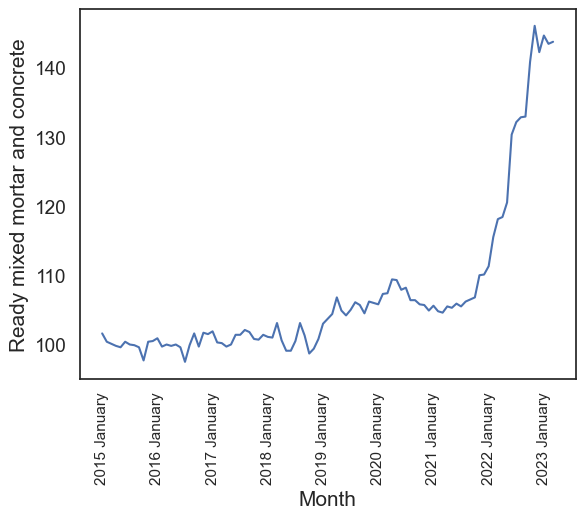

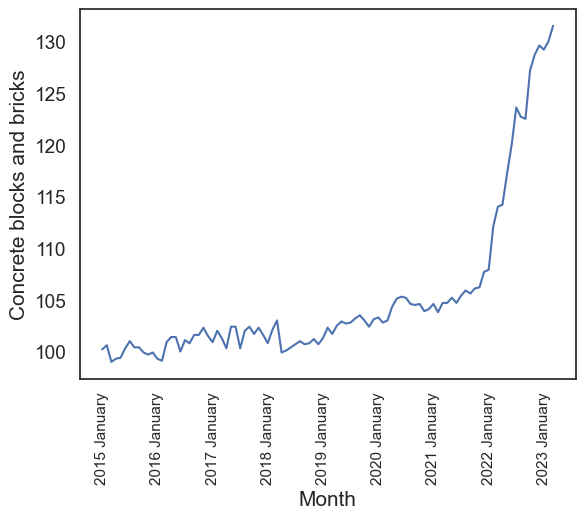

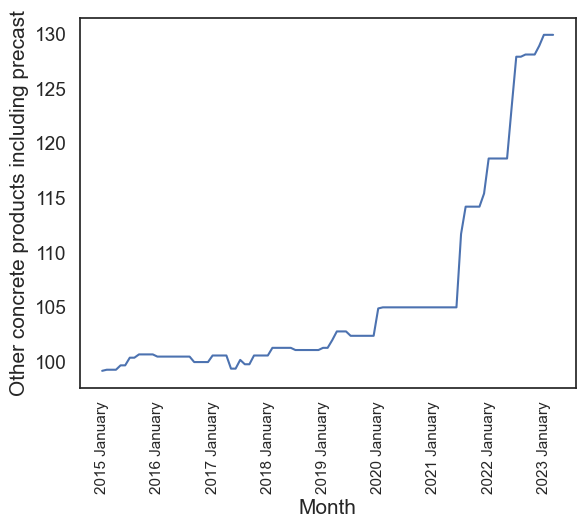

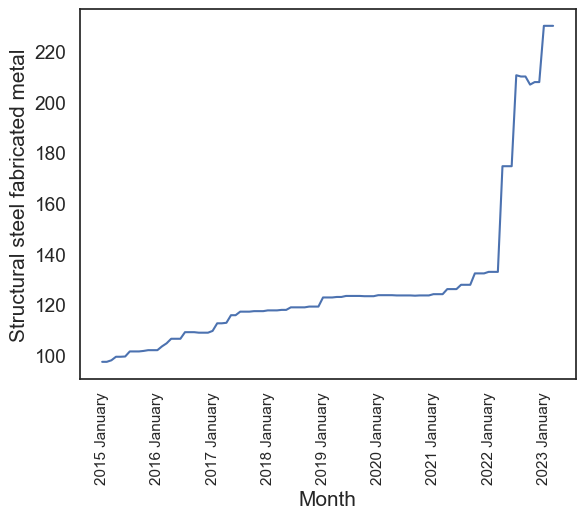

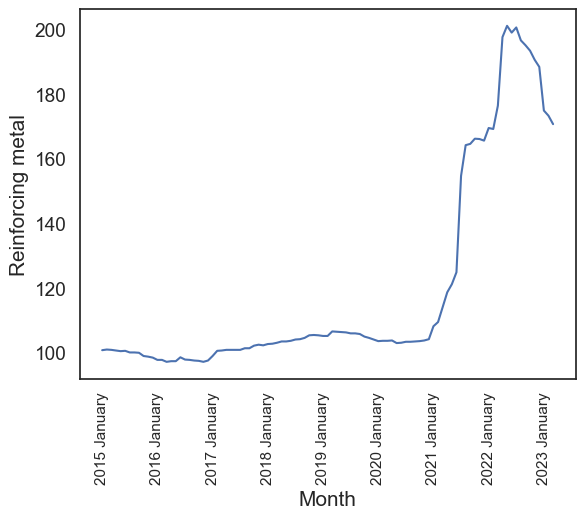

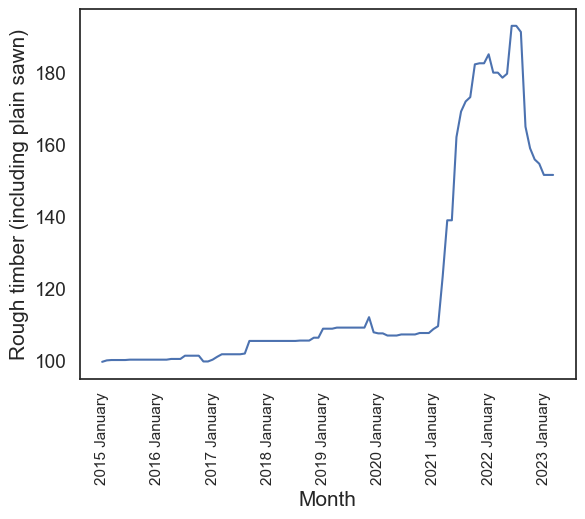

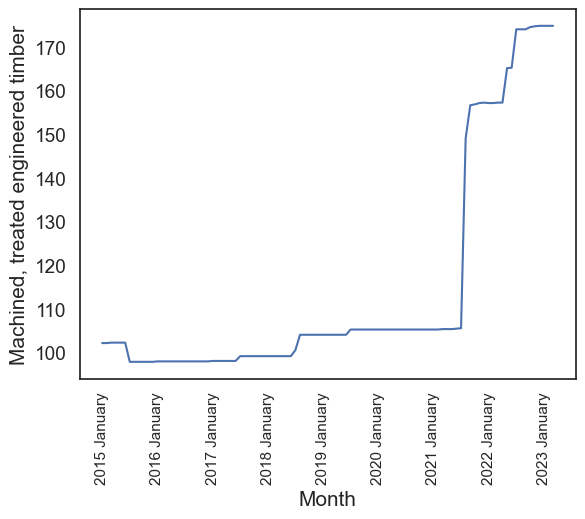

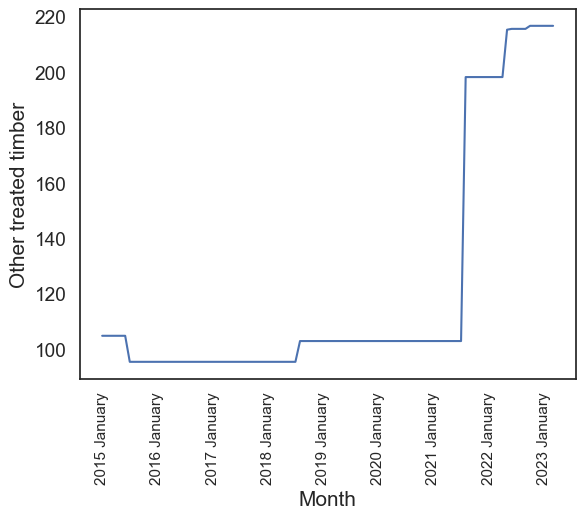

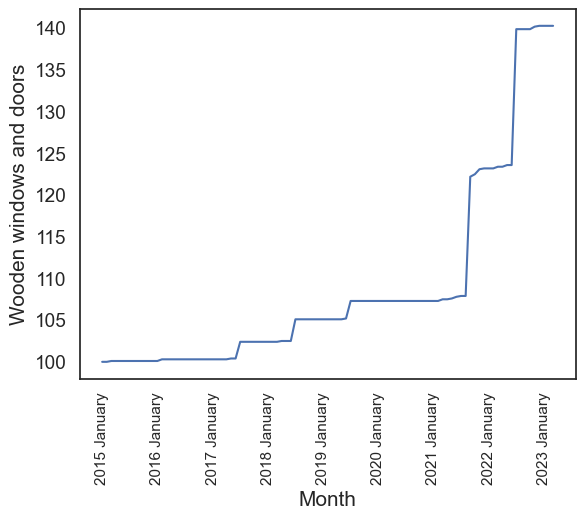

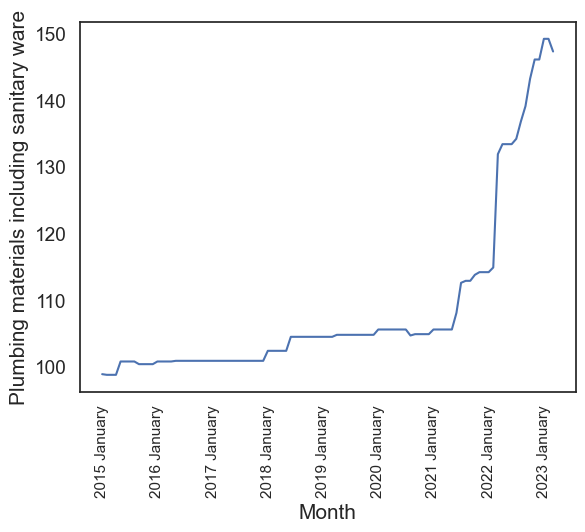

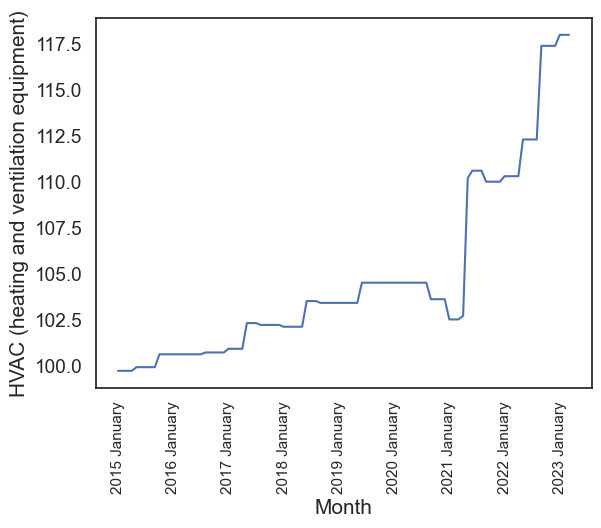

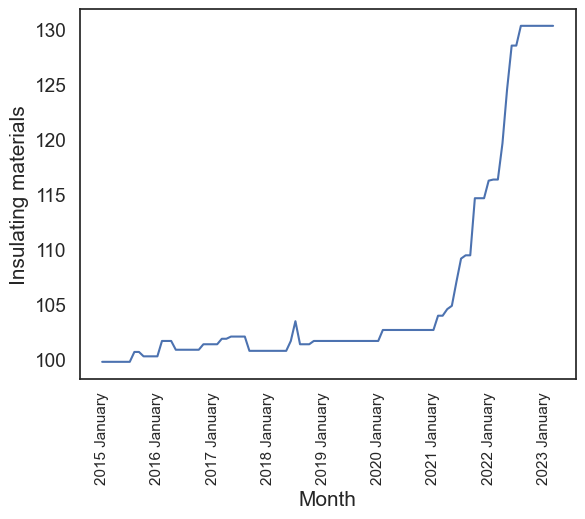

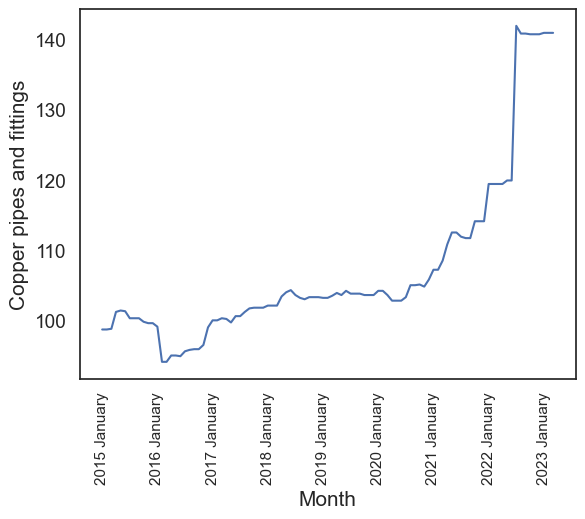

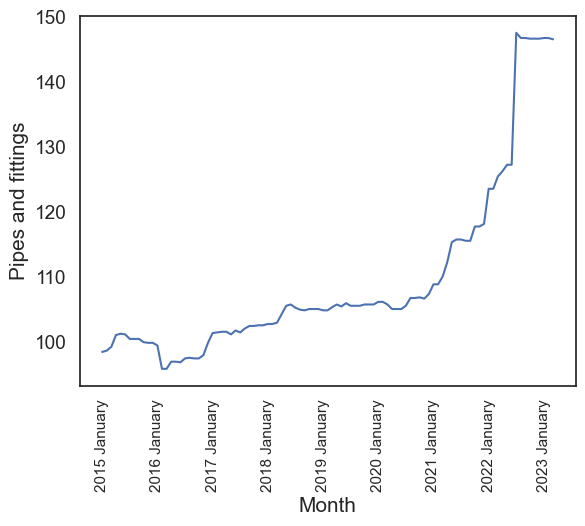

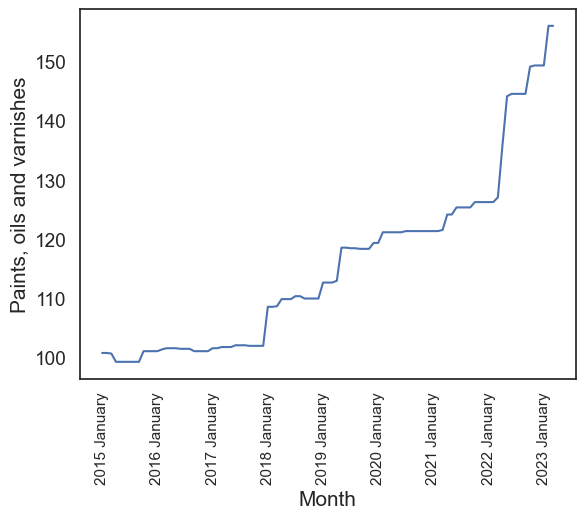

In [451]:
for i in new_ie_df.columns:
    plt.figure()
    plt.tight_layout()
    line_plot = sns.lineplot(data = new_ie_df,  x = new_ie_df.index, y = i)
    plt.xticks(plt.xticks()[0], rotation=90, size = 11)
    line_plot.xaxis.get_major_locator()  
    line_plot.xaxis.set_major_locator(ticker.MultipleLocator(12))

#### UK data Insights

In [456]:
uk_cols = common_list_dict.values()
print(list(uk_cols))

['Cement', 'Sand & gravel - including levy', 'Ready-mixed concrete **', 'of which : Blocks, bricks, tiles  & flagstones', 'Pre-cast concrete products', 'Fabricated structural steel', 'Concrete reinforcing bars (steel)', 'Imported sawn or planed wood', 'Imported plywood', 'Particle Board **', 'of which : Doors & windows **', 'Taps and Valves for sanitaryware', 'Electric water heaters *', 'Insulating materials (thermal or acoustic)', 'Pipes and fittings (rigid) **', 'Pipes and fittings (flexible) **', 'Paint (non-aqueous)']


In [459]:
uk_cols = list(uk_cols)
new_uk_df = uk_df[uk_cols]
new_uk_df

Type of Material  Cement  Sand & gravel - including levy  \
Month                                                      
2017 February      119.9                           121.7   
2017 March         120.5                           121.7   
2017 April         119.6                           121.6   
2017 May           117.6                           121.7   
2017 June          117.6                           121.3   
2017 July          117.6                           121.9   
2017 August        117.6                           121.3   
2017 September     117.6                           121.0   
2017 October       118.0                           121.0   
2017 November      118.0                           121.0   
2017 December      118.0                           121.0   
2018 January       118.6                           121.0   
2018 February      118.7                           121.0   
2018 March         118.8                           121.0   
2018 April         119.8                           121.0   
2018 May           119.6                           121.0   
2018 June          119.6                           121.0   
2018 July          119.6                           121.0   
2018 August        120.6                           121.0   
2018 September     120.6                           121.0   
2018 October       120.5                           121.0   
2018 November      121.1                           121.0   
2018 December      121.3                           121.0   
2019 January       122.7                           121.0   
2019 February      123.1                           121.0   
2019 March         124.5                           121.0   
2019 April         124.7                           121.0   
2019 May           124.9                           121.0   
2019 June          124.8                           121.0   
2019 July          125.1                           121.0   
2019 August        124.8                           121.0   
2019 September     124.7                           121.0   
2019 October       124.5                           121.0   
2019 November      124.3                           121.0   
2019 December      124.2                           121.0   
2020 January       127.0                           121.0   
2020 February      127.4                           121.0   
2020 March         107.8                           114.8   
2020 April         107.8                           114.8   
2020 May           107.8                           114.8   
2020 June          107.8                           117.3   
2020 July          107.0                           117.5   
2020 August        107.4                           117.5   
2020 September     107.9                           117.5   
2020 October       106.9                           119.1   
2020 November      107.1                           134.5   
2020 December      106.8                           134.5   
2021 January       108.1                           137.1   
2021 February      108.3                           141.5   
2021 March         109.6                           122.8   
2021 April         110.1                           122.3   
2021 May           111.1                           122.3   
2021 June          111.0                           122.8   
2021 July          110.9                           122.8   
2021 August        110.9                           122.8   
2021 September     111.3                           124.5   
2021 October       113.1                           127.0   
2021 November      113.9                           127.0   
2021 December      113.9                           127.0   
2022 January       115.1                           132.6   
2022 February      120.1                           132.6   
2022 March         121.7                           130.4   
2022 April         124.3                           137.3   
2022 May           124.3                           166.2   
2022 June          127.2                

In [460]:
avg_monthly_pct_change = new_uk_df.pct_change(periods=1) * 100
avg_monthly_pct_change = avg_monthly_pct_change.fillna(0)
avg_monthly_pct_change

Type of Material     Cement  Sand & gravel - including levy  \
Month                                                         
2017 February      0.000000                        0.000000   
2017 March         0.500417                        0.000000   
2017 April        -0.746888                       -0.082169   
2017 May          -1.672241                        0.082237   
2017 June          0.000000                       -0.328677   
2017 July          0.000000                        0.494641   
2017 August        0.000000                       -0.492207   
2017 September     0.000000                       -0.247321   
2017 October       0.340136                        0.000000   
2017 November      0.000000                        0.000000   
2017 December      0.000000                        0.000000   
2018 January       0.508475                        0.000000   
2018 February      0.084317                        0.000000   
2018 March         0.084246                        0.000000   
2018 April         0.841751                        0.000000   
2018 May          -0.166945                        0.000000   
2018 June          0.000000                        0.000000   
2018 July          0.000000                        0.000000   
2018 August        0.836120                        0.000000   
2018 September     0.000000                        0.000000   
2018 October      -0.082919                        0.000000   
2018 November      0.497925                        0.000000   
2018 December      0.165153                        0.000000   
2019 January       1.154163                        0.000000   
2019 February      0.325998                        0.000000   
2019 March         1.137287                        0.000000   
2019 April         0.160643                        0.000000   
2019 May           0.160385                        0.000000   
2019 June         -0.080064                        0.000000   
2019 July          0.240385                        0.000000   
2019 August       -0.239808                        0.000000   
2019 September    -0.080128                        0.000000   
2019 October      -0.160385                        0.000000   
2019 November     -0.160643                        0.000000   
2019 December     -0.080451                        0.000000   
2020 January       2.254428                        0.000000   
2020 February      0.314961                        0.000000   
2020 March       -15.384615                       -5.123967   
2020 April         0.000000                        0.000000   
2020 May           0.000000                        0.000000   
2020 June          0.000000                        2.177700   
2020 July         -0.742115                        0.170503   
2020 August        0.373832                        0.000000   
2020 September     0.465549                        0.000000   
2020 October      -0.926784                        1.361702   
2020 November      0.187091                       12.930311   
2020 December     -0.280112                        0.000000   
2021 January       1.217228                        1.933086   
2021 February      0.185014                        3.209336   
2021 March         1.200369                      -13.215548   
2021 April         0.456204                       -0.407166   
2021 May           0.908265                        0.000000   
2021 June         -0.090009                        0.408831   
2021 July         -0.090090                        0.000000   
2021 August        0.000000                        0.000000   
2021 September     0.360685                        1.384365   
2021 October       1.617251                        2.008032   
2021 November      0.707339                        0.000000   
2021 December      0.000000                        0.000000   
2022 January       1.053556                        4.409449   
2022 February      4.344049                        0.000000   
2022 March         1.332223    

/var/folders/s2/43wrtj7n0jv6ln1rpm789j180000gn/T/ipykernel_92929/1824379638.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.1%}'.format(x/100) for x in vals])


[Text(5, 0, '0.27%'),
 Text(5, 0, '0.47%'),
 Text(5, 0, '0.23%'),
 Text(5, 0, '0.39%'),
 Text(5, 0, '0.57%'),
 Text(5, 0, '1.03%'),
 Text(5, 0, '1.05%'),
 Text(5, 0, '0.67%'),
 Text(5, 0, '0.39%'),
 Text(5, 0, '0.24%'),
 Text(5, 0, '0.24%'),
 Text(5, 0, '0.37%'),
 Text(-5, 0, '-0.08%'),
 Text(5, 0, '0.68%'),
 Text(5, 0, '0.29%'),
 Text(5, 0, '0.36%'),
 Text(5, 0, '0.16%')]

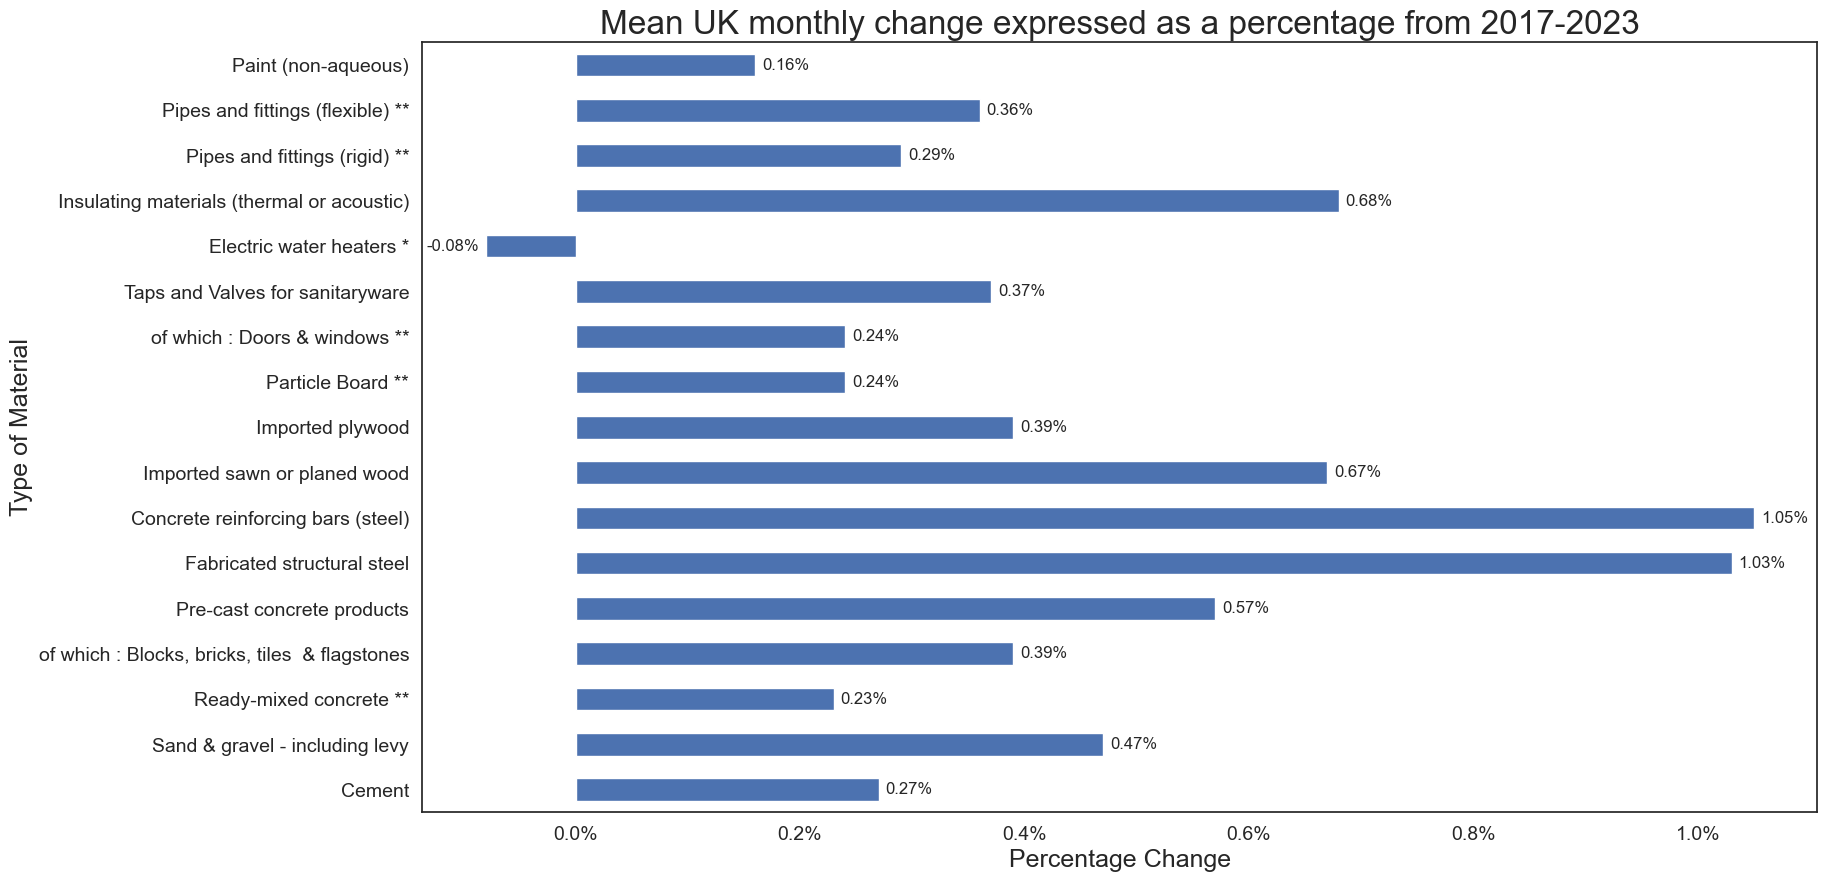

In [461]:
avg_monthly_pct_change = round(avg_monthly_pct_change.mean(), 2)

plt.figure(figsize=(18,10))
ax = avg_monthly_pct_change.plot.barh()

plt.title("Mean UK monthly change expressed as a percentage from 2017-2023", fontsize="24")
plt.xlabel("Percentage Change", fontsize="18")
plt.ylabel("Type of Material", fontsize="18")
plt.xticks(size = 14)
plt.yticks(size = 14)

vals = ax.get_xticks()
ax.set_xticklabels(['{:,.1%}'.format(x/100) for x in vals])

plt.bar_label(ax.containers[0], padding = 5 , size=12 , fmt='%.2f%%')

In [462]:
avg_monthly_pct_change.sort_values(ascending = False)

Type of Material
Concrete reinforcing bars (steel)                 1.05
Fabricated structural steel                       1.03
Insulating materials (thermal or acoustic)        0.68
Imported sawn or planed wood                      0.67
Pre-cast concrete products                        0.57
Sand & gravel - including levy                    0.47
Imported plywood                                  0.39
of which : Blocks, bricks, tiles  & flagstones    0.39
Taps and Valves for sanitaryware                  0.37
Pipes and fittings (flexible) **                  0.36
Pipes and fittings (rigid) **                     0.29
Cement                                            0.27
of which : Doors & windows **                     0.24
Particle Board **                                 0.24
Ready-mixed concrete **                           0.23
Paint (non-aqueous)                               0.16
Electric water heaters *                         -0.08
dtype: float64

/var/folders/s2/43wrtj7n0jv6ln1rpm789j180000gn/T/ipykernel_92929/3788147265.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.1%}'.format(x/100) for x in vals])


[Text(5, 0, '3.24%'),
 Text(5, 0, '5.64%'),
 Text(5, 0, '2.76%'),
 Text(5, 0, '4.68%'),
 Text(5, 0, '6.84%'),
 Text(5, 0, '12.36%'),
 Text(5, 0, '12.60%'),
 Text(5, 0, '8.04%'),
 Text(5, 0, '4.68%'),
 Text(5, 0, '2.88%'),
 Text(5, 0, '2.88%'),
 Text(5, 0, '4.44%'),
 Text(-5, 0, '-0.96%'),
 Text(5, 0, '8.16%'),
 Text(5, 0, '3.48%'),
 Text(5, 0, '4.32%'),
 Text(5, 0, '1.92%')]

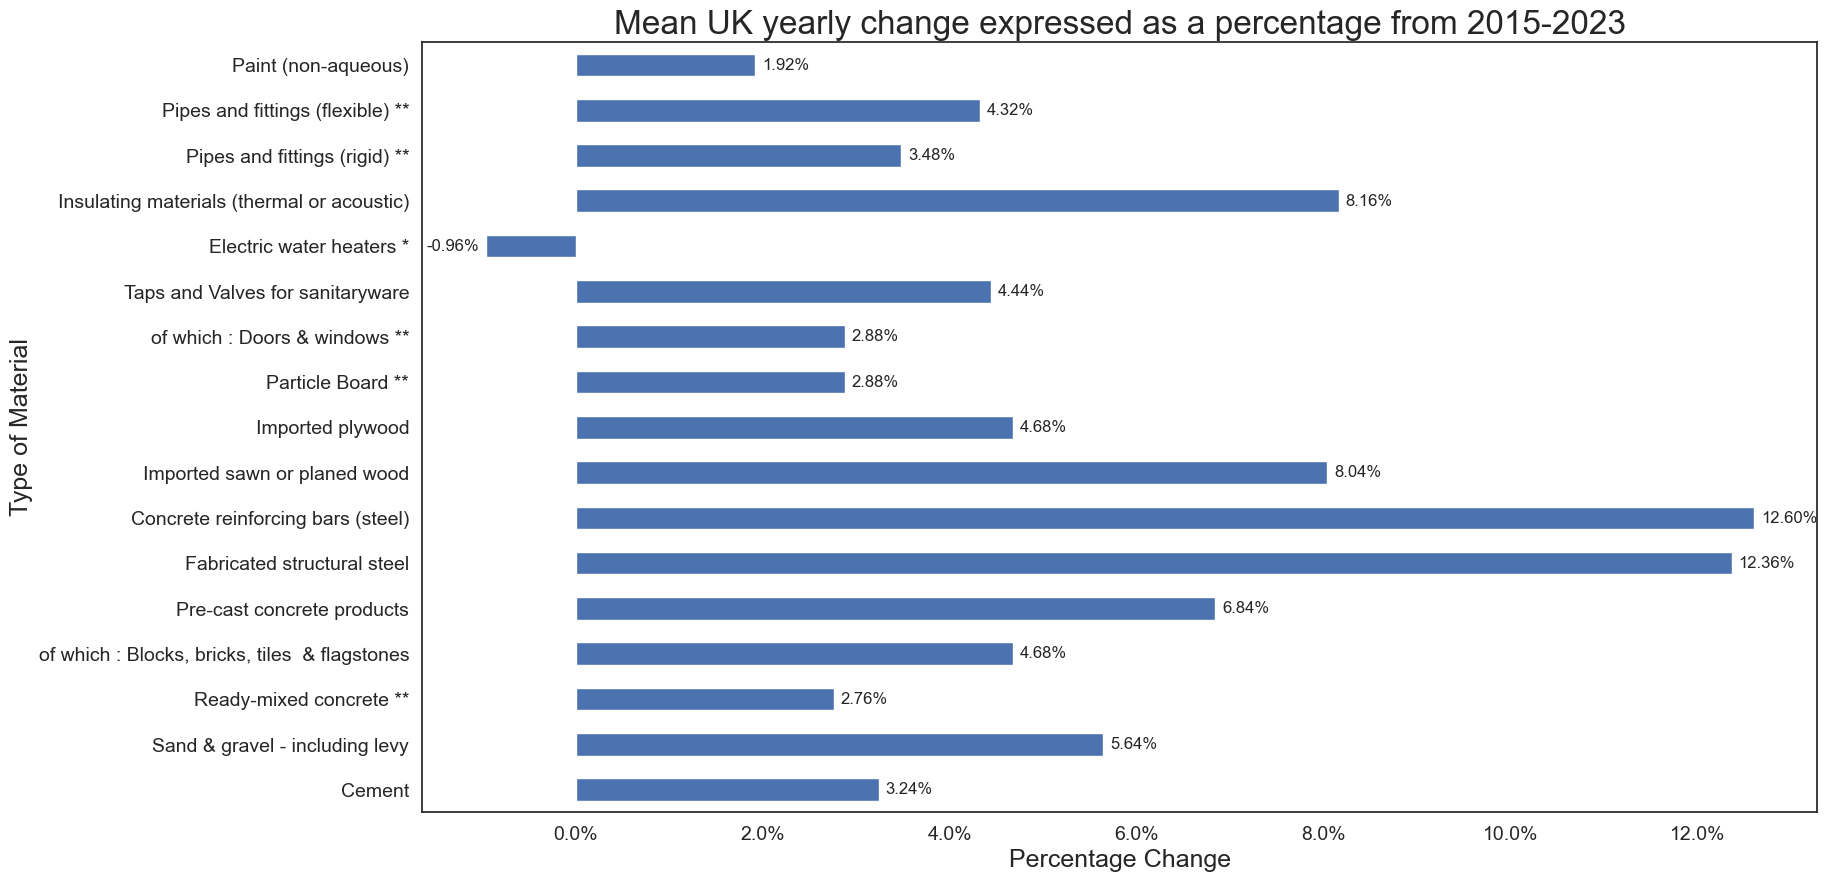

In [463]:
avg_yearly_pct_change = avg_monthly_pct_change * 12

plt.figure(figsize=(18,10))
ax = avg_yearly_pct_change.plot.barh()

plt.title("Mean UK yearly change expressed as a percentage from 2015-2023", fontsize="24")
plt.xlabel("Percentage Change", fontsize="18")
plt.ylabel("Type of Material", fontsize="18")
plt.xticks(size = 14)
plt.yticks(size = 14)

vals = ax.get_xticks()
ax.set_xticklabels(['{:,.1%}'.format(x/100) for x in vals])

plt.bar_label(ax.containers[0], padding = 5 , size=12 , fmt='%.2f%%')

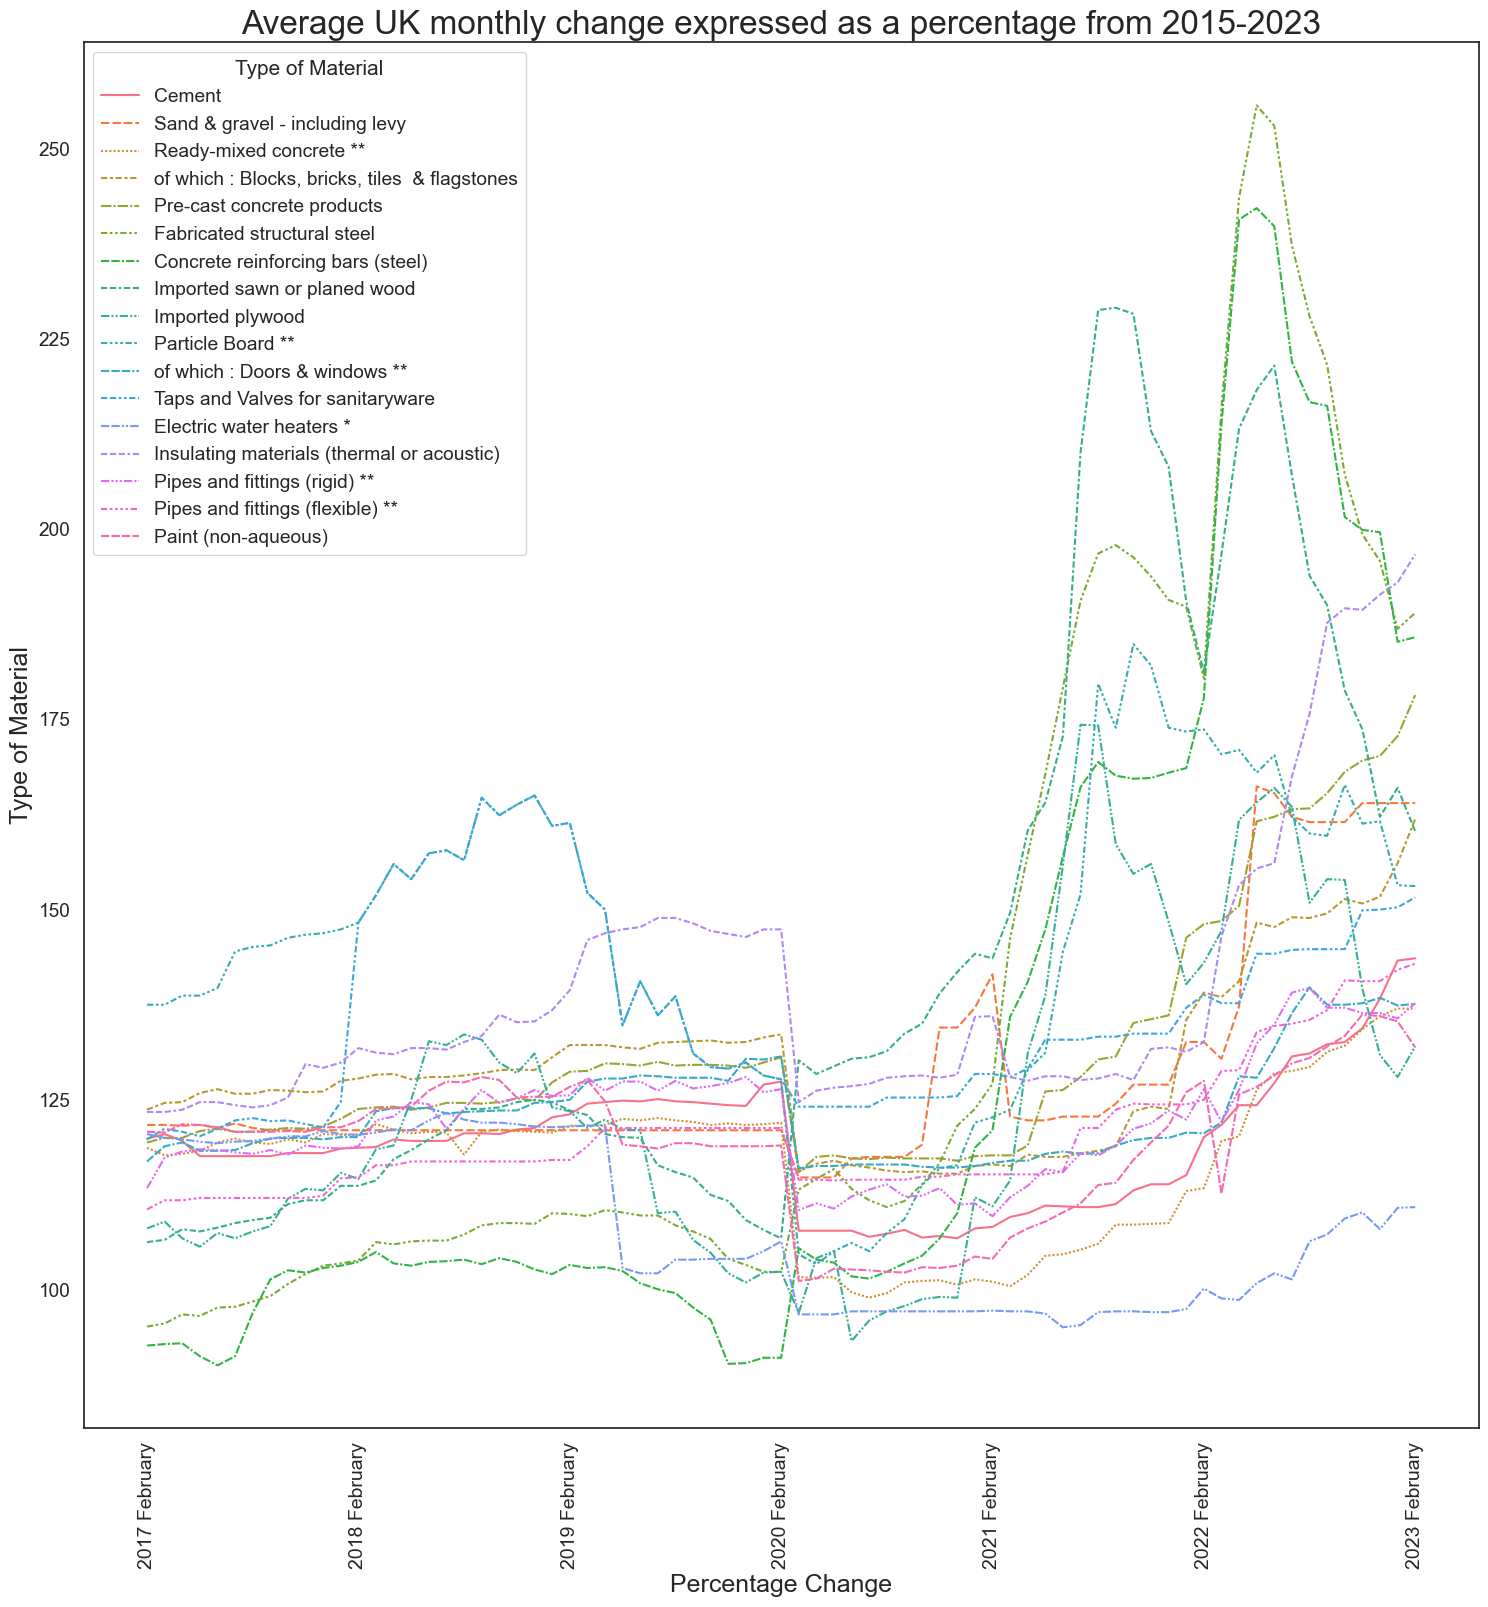

In [464]:
plt.figure(figsize=(18,18))

sns_plot = sns.lineplot(data = new_uk_df , ci = None)

plt.title("Average UK monthly change expressed as a percentage from 2015-2023", fontsize="24")
plt.xlabel("Percentage Change", fontsize="18")
plt.ylabel("Type of Material", fontsize="18")
plt.xticks(plt.xticks()[0], rotation=90, size = 14)
sns_plot.xaxis.get_major_locator()  
sns_plot.xaxis.set_major_locator(ticker.MultipleLocator(12))

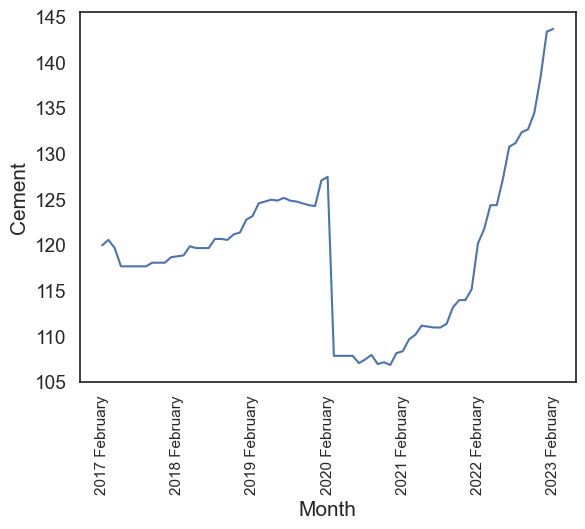

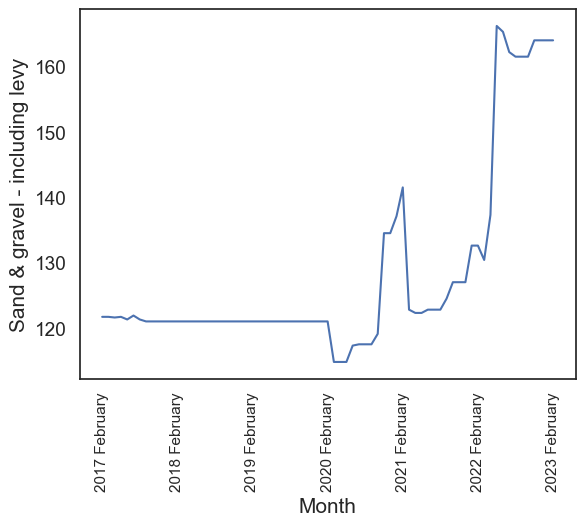

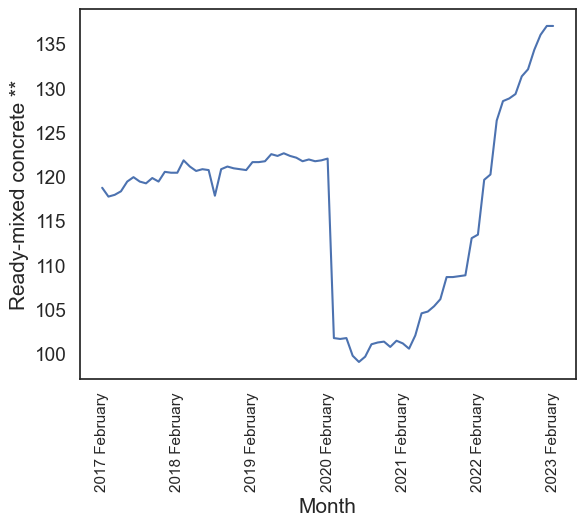

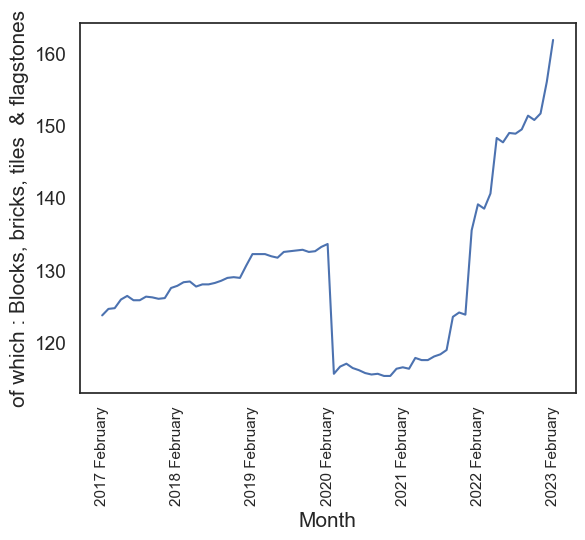

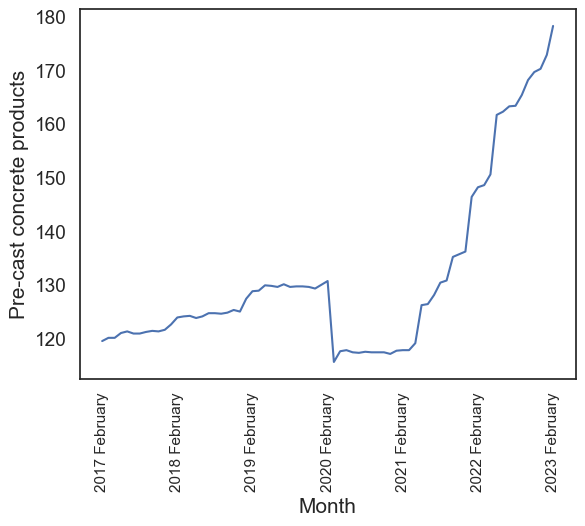

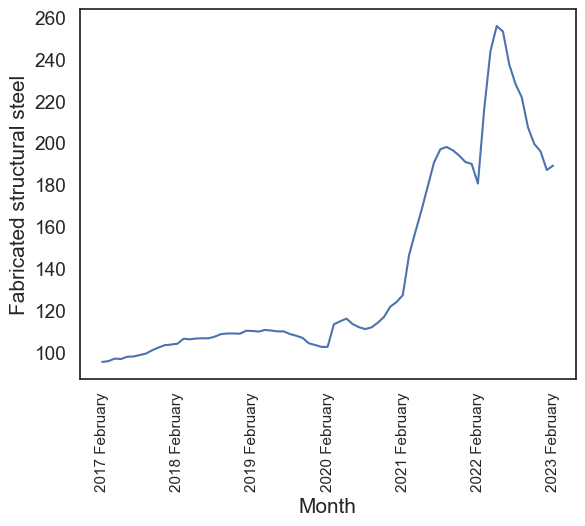

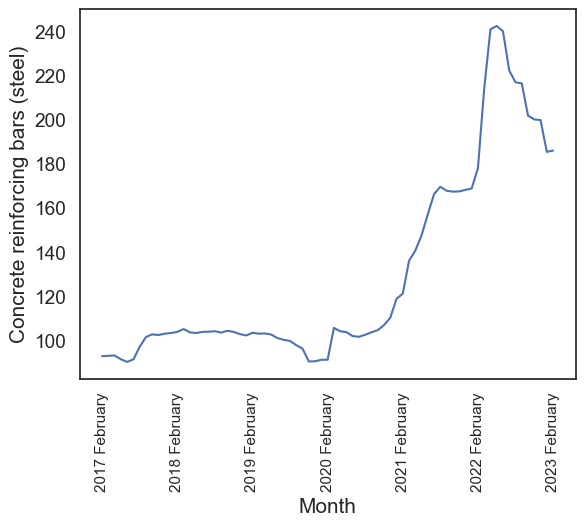

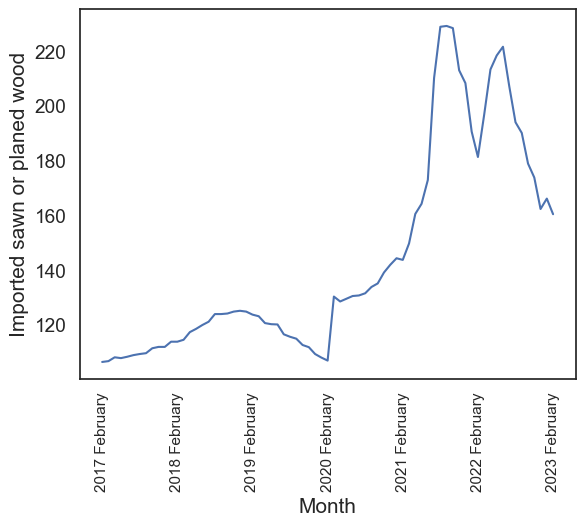

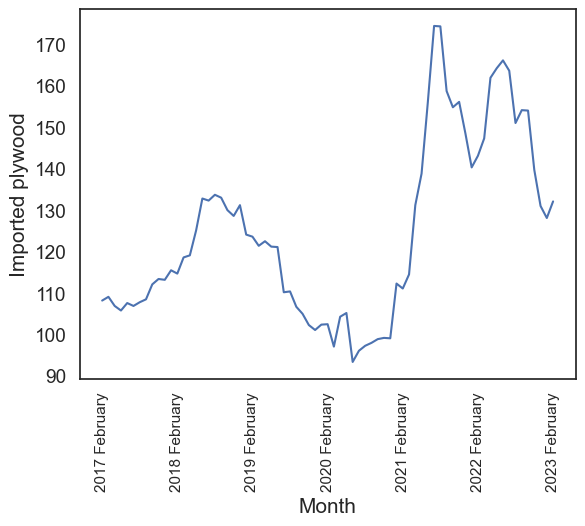

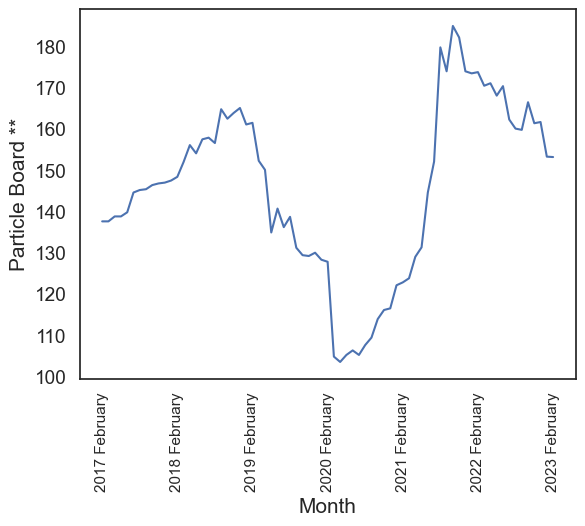

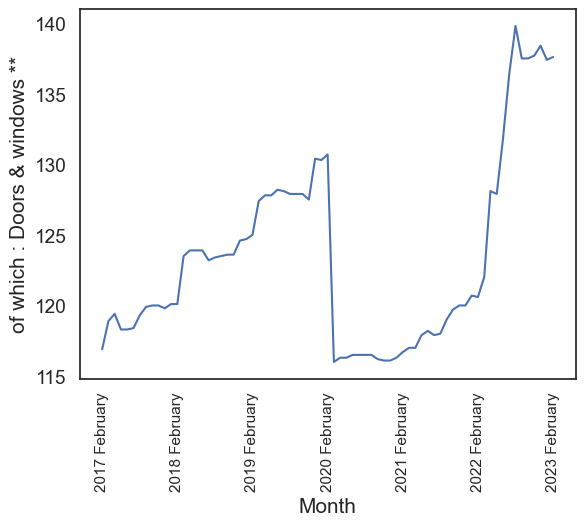

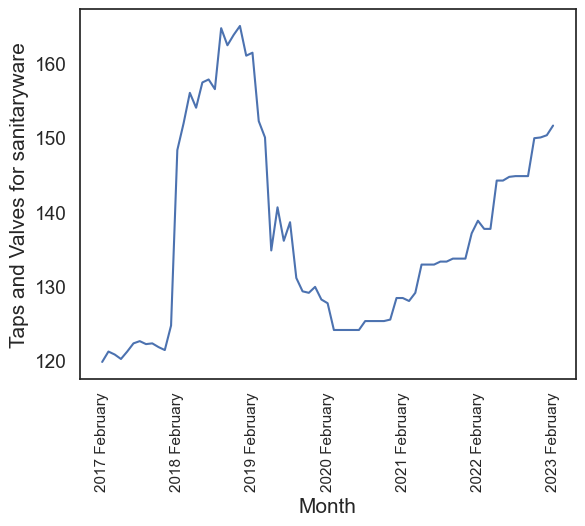

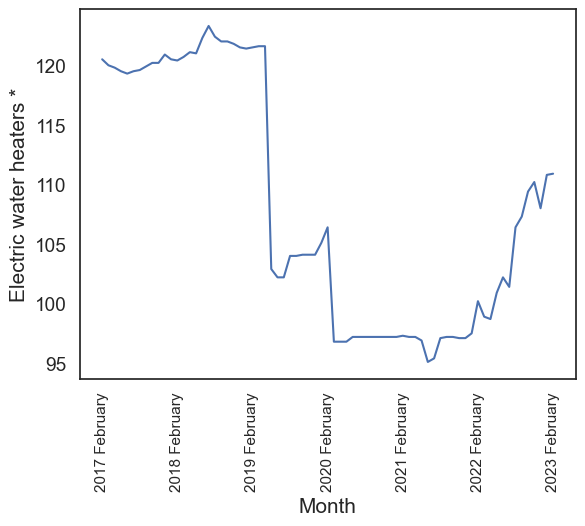

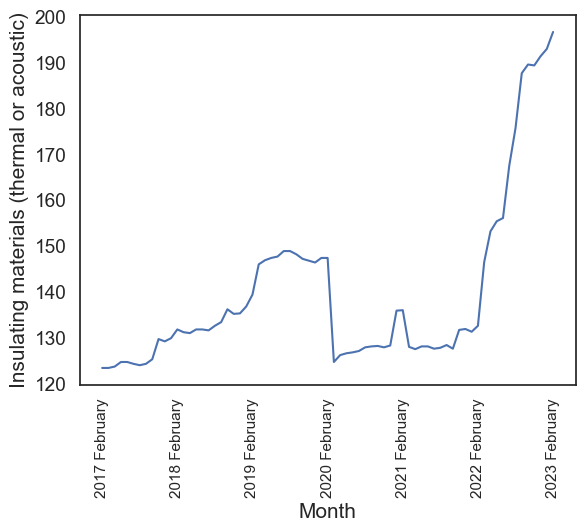

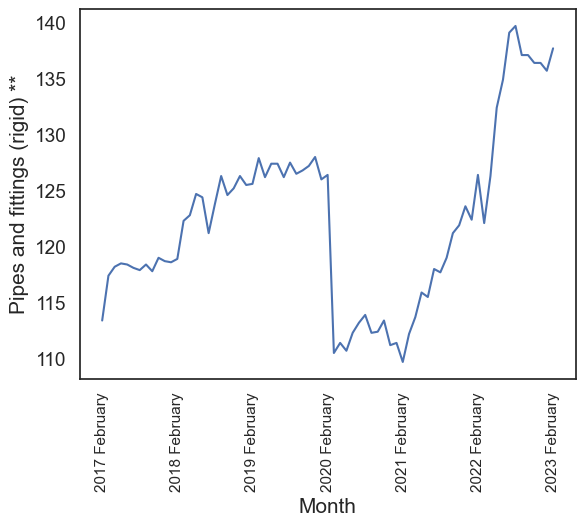

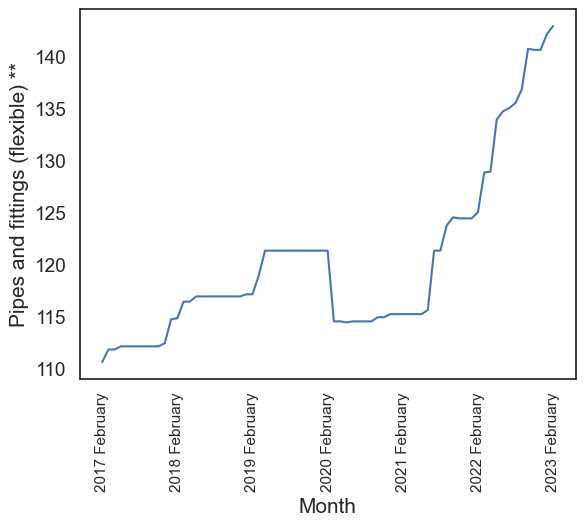

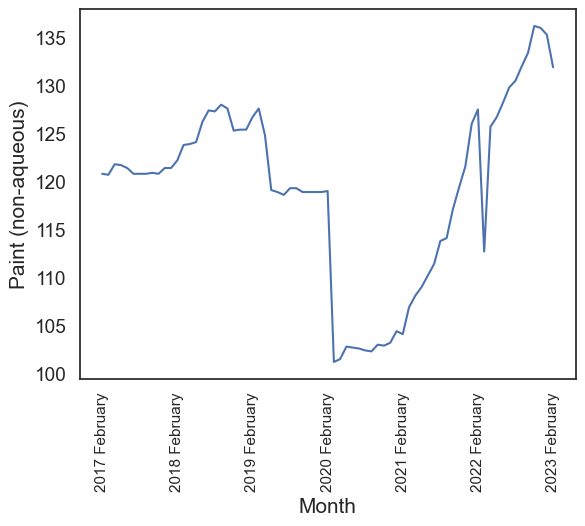

In [468]:
for i in new_uk_df.columns:
    plt.figure()
    plt.tight_layout()
    line_plot = sns.lineplot(data = new_uk_df,  x = new_uk_df.index, y = i)
    plt.xticks(plt.xticks()[0], rotation=90, size = 11)
    line_plot.xaxis.get_major_locator()  
    line_plot.xaxis.set_major_locator(ticker.MultipleLocator(12))